# Analyse Protein Flexibility and Similarity of MicroMiner Hits
In this notebook the MicroMiner hits are analyzed whether they are reasonable single mutations. 
In addition, we evaluate how structurally different the reported environments can be on the local
and global level.

Experiments:
* Local Calpha RMSD of the hit environments
* Global structure/sequence similarity with established measures. 


In [1]:
%matplotlib inline

import warnings
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import tempfile
import json
from pathlib import Path
import multiprocessing
import itertools
import pickle
import gzip
import io
import string
from Bio.PDB import PDBParser, Select, PDBIO
from scipy import stats
import matplotlib.gridspec as gridspec
from scipy.stats import bootstrap


# project root dir
root_dir = Path('/local/sieg/projekte/microminer_evaluation')
sys.path.insert(0, str(root_dir.resolve()))

import helper
from helper.constants import one_2_three_dict, three_2_one_dict
from helper.tmalign import call_tmalign, parse_stdout
from helper.utils import unpack_gz
from helper.datasets.utils import get_pdb_file_path

In [2]:
plots_outdir = Path('/local/sieg/projekte/microminer_evaluation/plots')

In [3]:
PDB_CACHE_DIR = Path('/local/sieg/unpacked_pdb_cache')
TMALIGN_CACHE_FILE = Path('/local/sieg/tmalign_sims.csv')

In [4]:
exp_search_dir = root_dir / 'results' / 'mutation_benchmark' / 'search'

dataset_collection = helper.get_dataset_collection()
datasets = [d.name for d in dataset_collection.get_mutation_datasets_with_structure_pairs()]
datasets

['protherm', 'platinum', 'thermomutdb', 'shanthirabalan']

In [5]:
# all the relevant columns microminer writes into its TSV 
microminer_cols = ['queryName', 'queryAA', 'queryChain', 'queryPos',
       'hitName', 'hitAA', 'hitChain', 'hitPos', 'siteIdentity',
       'siteBackBoneRMSD', 'siteAllAtomRMSD', 
       'nofSiteResidues', 'alignmentLDDT', 'fullSeqId']

In [6]:
df_problematic = pd.read_csv(root_dir / 'data' / 'problematic_single_mutations.tsv', sep='\t', header=0)
df_problematic

pdb_wild pdb_mutant wild_chain wild_aa  seq_num mutation_aa   
0       2LZM       128L          A       A       93           T  \
1       1POH       1SPH          A       S       46           A   
2       2LZM       1L68          A       N       68           A   
3       1LZ1       1GAY          A       V       74           G   
4       1LZ1       1GAZ          A       V       74           I   
..       ...        ...        ...     ...      ...         ...   
184     1CNQ       1YXI          A       A       54           L   
185     2TDM       1TSY          A       R      179           K   
186     2TDM       1TSV          A       R      179           A   
187     1AMK       1QDS          A       E       65           Q   
188     2JBZ       2WDS          A       H      110           A   

                           reason  
0                          both A  
1                      to D not A  
2                          both N  
3                          both V  
4                          both V  
..                            ...  
184  PPI. Chain C missing in 1YXI  
185  PPI. Chain B missing in 1TSY  
186  PPI. Chain B missing in 1TSV  
187  PPI. Chain B missing in 1QDS  
188  PPI. Chain C missing in 2WDS  

[189 rows x 7 columns]

In [7]:
# read in MicroMiner result of single mutation benchmark
df_corrected_list = []
df_list = []
for dataset in datasets:
    print(f'Processing: {dataset}')
    df_found = pd.read_csv(exp_search_dir / dataset / 'report' / f'{dataset}_eval.tsv', sep='\t', header=0, 
                           dtype={'queryPos': str, 'hitPos': str, 'hitName': str, 'queryName': str})
    
    # use wild-type chain id if mutation data set has annotation for it
    relevant_cols_dataset = [helper.WILD_COL, helper.MUTANT_COL, helper.WILD_AA, helper.MUT_AA, helper.WILD_SEQ_NUM]
    relevant_cols_reviewed_mutations = ['pdb_wild', 'pdb_mutant', 'wild_aa', 'mutation_aa', 'seq_num']
    if helper.WILD_CHAIN in df_found.columns:
        relevant_cols_dataset.append(helper.WILD_CHAIN)
        relevant_cols_reviewed_mutations.append('wild_chain')
        
    # Correct df_found dataframe to only contain the found mutation and the ones NOT in the list of problematic mutations 
    df_merged = df_found.merge(df_problematic, left_on=relevant_cols_dataset,
                               right_on=relevant_cols_reviewed_mutations,
                               how='left', indicator=True)
    df_found_corrected = df_merged[df_merged['_merge'] == 'left_only']
    df_found_corrected = df_found_corrected.drop('_merge', axis=1)
    
    # keep the corrected version of the mutations
    df_found_corrected['dataset'] = dataset
    df_corrected_list.append(df_found_corrected)
    
    # keep the original version of the mutations
    df_found['dataset'] = dataset
    df_list.append(df_found)

Processing: protherm
Processing: platinum
Processing: thermomutdb
Processing: shanthirabalan


In [8]:
# generate dataframes containing only the MicroMiner results.
# We need to do this to stack the results from the different datasets. Not-found mutations will be NaN/unidentifiable
df_corrected_all = pd.concat([_df[microminer_cols + ['dataset']] for _df in df_corrected_list])
df_all = pd.concat([_df[microminer_cols + ['dataset']] for _df in df_list])

In [9]:
df_corrected_all

queryName queryAA queryChain queryPos hitName hitAA hitChain hitPos   
0        2RN2     LYS          A       95    1RBT   GLY        A     95  \
1        2RN2     LYS          A       95    1RBV   ALA        A     95   
2        2RN2     LYS          A       95    1RBU   ASN        A     95   
3        1IOB     THR          A        9    1HIB   GLY        A      9   
4        1BNI     LEU          A       14    1BRH   ALA        A     14   
..        ...     ...        ...      ...     ...   ...      ...    ...   
541      4BFL     PHE          A      413    3TTT   TYR        A    413   
542      4BFL     GLU          A      530    4ENP   ALA        A    530   
543      4BFL     GLU          A      530    4ENS   GLN        A    530   
544      4BFL     SER          A      234    4ENV   ILE        A    234   
545      4BFL     SER          A      234    4ENW   ASN        A    234   

     siteIdentity  siteBackBoneRMSD  siteAllAtomRMSD  nofSiteResidues   
0           0.875             0.177            0.453              8.0  \
1           0.875             0.126            0.274              8.0   
2           0.875             0.185            0.465              8.0   
3           0.933             1.103            1.670             15.0   
4           0.944             0.325            0.744             18.0   
..            ...               ...              ...              ...   
541         0.917             0.265            0.665             12.0   
542         0.952             0.140            0.219             21.0   
543         0.952             0.140            0.237             21.0   
544         0.947             0.188            0.244             19.0   
545         0.947             0.095            0.126             19.0   

     alignmentLDDT  fullSeqId         dataset  
0            1.000      0.994        protherm  
1            1.000      0.994        protherm  
2            1.000      0.994        protherm  
3            0.829      0.974        protherm  
4            0.984      0.991        protherm  
..             ...        ...             ...  
541          0.981      0.974  shanthirabalan  
542          1.000      0.974  shanthirabalan  
543          0.999      0.974  shanthirabalan  
544          0.996      0.974  shanthirabalan  
545          1.000      0.974  shanthirabalan  

[1194 rows x 15 columns]

In [10]:
df_all[df_all.isna().any(axis=1)]

queryName queryAA queryChain queryPos hitName hitAA hitChain hitPos   
14        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN  \
54        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
71        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
72        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
75        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
..        ...     ...        ...      ...     ...   ...      ...    ...   
425       NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
426       NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
12        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
74        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
82        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   

     siteIdentity  siteBackBoneRMSD  siteAllAtomRMSD  nofSiteResidues   
14            NaN               NaN              NaN              NaN  \
54            NaN               NaN              NaN              NaN   
71            NaN               NaN              NaN              NaN   
72            NaN               NaN              NaN              NaN   
75            NaN               NaN              NaN              NaN   
..            ...               ...              ...              ...   
425           NaN               NaN              NaN              NaN   
426           NaN               NaN              NaN              NaN   
12            NaN               NaN              NaN              NaN   
74            NaN               NaN              NaN              NaN   
82            NaN               NaN              NaN              NaN   

     alignmentLDDT  fullSeqId         dataset  
14             NaN        NaN        protherm  
54             NaN        NaN        protherm  
71             NaN        NaN        protherm  
72             NaN        NaN        protherm  
75             NaN        NaN        protherm  
..             ...        ...             ...  
425            NaN        NaN     thermomutdb  
426            NaN        NaN     thermomutdb  
12             NaN        NaN  shanthirabalan  
74             NaN        NaN  shanthirabalan  
82             NaN        NaN  shanthirabalan  

[238 rows x 15 columns]

In [11]:
### EXTRACT ALL HITS FOUND BY MM

files = []
all_benchmark_wild_type_ids = set()
for dataset in datasets:    
    dataset_obj = dataset_collection.get_dataset(dataset)
    df_muts = dataset_obj.read_single_mutations(pdb_mutant_only=True)
    wild_type_set = set(df_muts[helper.WILD_COL])
    all_benchmark_wild_type_ids.update(wild_type_set)
    
    path = exp_search_dir / dataset 
    files.extend([(p, dataset) for p in helper.utils.scantree(path) if p.name == 'resultStatistic.csv' and p.parent.name in wild_type_set])
    
mm_dtypes = {'queryPos': str, 'hitPos': str, 'hitName': str, 'queryName': str, 'nofSiteResidues': int,
             'queryChain': str, 'hitChain': str}
site_key = ['queryName', 'queryAA', 'queryChain', 'queryPos',
            'hitName', 'hitAA', 'hitChain', 'hitPos']
df_list_full_mm_hits = []
for path, dataset in files:
    _df = pd.read_csv(path, sep='\t', header=0, dtype=mm_dtypes)
    _df['dataset'] = dataset
    df_list_full_mm_hits.append(_df)
df_full_mm_hits = pd.concat(df_list_full_mm_hits).drop_duplicates(subset=site_key)
_df = None
df_list_full_mm_hits = None
assert df_full_mm_hits['dataset'].unique().__len__() == len(datasets)
df_full_mm_hits

queryName queryAA queryChain queryPos hitName hitAA hitChain hitPos   
0         2RN2     GLN          A        4    2Z1G   ARG        A      4  \
1         2RN2     GLN          A        4    2Z1H   ARG        A      4   
2         2RN2     GLN          A        4    2Z1I   ARG        A      4   
3         2RN2     GLN          A        4    2Z1I   ARG        B      4   
4         2RN2     GLN          A        4    2Z1J   ARG        A      4   
...        ...     ...        ...      ...     ...   ...      ...    ...   
1254      4BFL     ILE          D      710    6JQQ   VAL        D    710   
1255      4BFL     LYS          D      750    5BV2   SER        P    750   
1256      4BFL     LYS          D      750    5BV2   SER        Q    750   
1257      4BFL     LYS          D      750    5BV2   SER        R    750   
1258      4BFL     LYS          D      750    5BV2   SER        S    750   

      siteIdentity  siteBackBoneRMSD  siteAllAtomRMSD  nofSiteResidues   
0            0.909             3.159            4.696               11  \
1            0.909             3.188            4.645               11   
2            0.909             3.192            4.726               11   
3            0.909             3.258            4.621               11   
4            0.909             3.206            4.673               11   
...            ...               ...              ...              ...   
1254         0.944             0.317            0.711               18   
1255         0.875             0.110            0.827                8   
1256         0.875             0.105            0.366                8   
1257         0.875             0.098            0.374                8   
1258         0.875             0.105            0.363                8   

      alignmentLDDT  fullSeqId         dataset  
0             0.755      0.955        protherm  
1             0.759      0.955        protherm  
2             0.759      0.916        protherm  
3             0.768      0.916        protherm  
4             0.750      0.903        protherm  
...             ...        ...             ...  
1254          0.995      0.978  shanthirabalan  
1255          1.000      0.976  shanthirabalan  
1256          1.000      0.977  shanthirabalan  
1257          1.000      0.976  shanthirabalan  
1258          1.000      0.976  shanthirabalan  

[137325 rows x 15 columns]

In [12]:
print(f'There are {len(all_benchmark_wild_type_ids)} unique query proteins in the {len(datasets)} benchmark data sets ')

There are 124 unique query proteins in the 4 benchmark data sets 


In [13]:
df_full_mm_hits.sort_values('siteBackBoneRMSD').dropna().tail(n=15)

queryName queryAA queryChain queryPos hitName hitAA hitChain hitPos   
12        2RDE     LEU          B      135    3KYG   ARG        A    135  \
13        2RDE     LEU          B      135    3KYG   ARG        B    135   
3         3MON     ARG          A        2    5XFU   TYR        E     48   
206       2ITY     GLU          A      865    6S89   ALA        A    865   
207       2ITY     GLU          A      865    6S8A   ALA        A    865   
1205      4TYU     PRO          A       91    8CXN   ILE        E     88   
293       3ZCF     VAL          A       83    5ZKV   ALA        A     83   
1254      3ZCF     VAL          D       83    5ZKV   ALA        A     83   
7139      4TYU     PRO          B       91    8CXN   ILE        E     88   
66        1EY0     GLU          A       43    2M00   SER        A     43   
64        1STN     GLU          A       43    2M00   SER        A     43   
204       4FMP     PHE          B       25    2W22   LEU        A     26   
2         4FMP     PHE          A       25    2W22   LEU        A     26   
205       4FMP     PHE          B       25    5CE5   LEU        A     26   
3         4FMP     PHE          A       25    5CE5   LEU        A     26   

      siteIdentity  siteBackBoneRMSD  siteAllAtomRMSD  nofSiteResidues   
12           0.923             4.507            5.708               13  \
13           0.923             4.538            5.711               13   
3            0.900             4.575            4.330               10   
206          0.857             4.584            4.325                7   
207          0.857             4.619            4.318                7   
1205         0.923             4.648            5.167               13   
293          0.917             4.705            5.308               12   
1254         0.917             4.730            5.354               12   
7139         0.923             4.778            5.463               13   
66           0.950             5.022            6.131               20   
64           0.947             5.028            6.187               19   
204          0.929             5.689            6.570               14   
2            0.929             5.702            6.650               14   
205          0.929             5.787            6.632               14   
3            0.929             5.800            6.718               14   

      alignmentLDDT  fullSeqId      dataset  
12            0.657      0.970     platinum  
13            0.660      0.970     platinum  
3             0.667      0.489  thermomutdb  
206           0.476      0.939     platinum  
207           0.464      0.936     platinum  
1205          0.433      0.662  thermomutdb  
293           0.447      0.867  thermomutdb  
1254          0.458      0.867  thermomutdb  
7139          0.433      0.662  thermomutdb  
66            0.400      0.899  thermomutdb  
64            0.393      0.899     protherm  
204           0.604      0.948  thermomutdb  
2             0.599      0.948  thermomutdb  
205           0.604      0.948  thermomutdb  
3             0.593      0.948  thermomutdb

In [14]:
## DEFINE INPUT DATA TO TMALIGN
df = df_full_mm_hits#.query('nofSiteResidues >= 7')#.head(n=1000)

mirror_map = {'protherm': 'standard', 'thermomutdb': 'standard', 'shanthirabalan': 'standard',
              'platinum': 'platinum'}
df['query_mirror'] = df['dataset'].apply(lambda x: mirror_map[x])
df['queryChain'] = df['queryChain'].astype(str)
df['hitChain'] = df['hitChain'].astype(str)
df['hit_mirror'] = 'standard'
cols = ['queryName', 'queryChain', 'hitName', 'hitChain', 'query_mirror', 'hit_mirror']
df_dups_rm = df.drop_duplicates(subset=cols).dropna(subset=cols)
df_dups_rm

queryName queryAA queryChain queryPos hitName hitAA hitChain hitPos   
0         2RN2     GLN          A        4    2Z1G   ARG        A      4  \
1         2RN2     GLN          A        4    2Z1H   ARG        A      4   
2         2RN2     GLN          A        4    2Z1I   ARG        A      4   
3         2RN2     GLN          A        4    2Z1I   ARG        B      4   
4         2RN2     GLN          A        4    2Z1J   ARG        A      4   
...        ...     ...        ...      ...     ...   ...      ...    ...   
1195      4BFL     GLU          D      530    4ENR   ILE        D    530   
1196      4BFL     GLU          D      530    4ENS   GLN        A    530   
1197      4BFL     GLU          D      530    4ENS   GLN        B    530   
1198      4BFL     GLU          D      530    4ENS   GLN        C    530   
1199      4BFL     GLU          D      530    4ENS   GLN        D    530   

      siteIdentity  siteBackBoneRMSD  siteAllAtomRMSD  nofSiteResidues   
0            0.909             3.159            4.696               11  \
1            0.909             3.188            4.645               11   
2            0.909             3.192            4.726               11   
3            0.909             3.258            4.621               11   
4            0.909             3.206            4.673               11   
...            ...               ...              ...              ...   
1195         0.952             0.216            0.437               21   
1196         0.952             0.138            0.429               21   
1197         0.952             0.120            0.495               21   
1198         0.952             0.122            0.453               21   
1199         0.952             0.119            0.409               21   

      alignmentLDDT  fullSeqId         dataset query_mirror hit_mirror  
0             0.755      0.955        protherm     standard   standard  
1             0.759      0.955        protherm     standard   standard  
2             0.759      0.916        protherm     standard   standard  
3             0.768      0.916        protherm     standard   standard  
4             0.750      0.903        protherm     standard   standard  
...             ...        ...             ...          ...        ...  
1195          0.992      0.985  shanthirabalan     standard   standard  
1196          1.000      0.986  shanthirabalan     standard   standard  
1197          1.000      0.986  shanthirabalan     standard   standard  
1198          1.000      0.986  shanthirabalan     standard   standard  
1199          1.000      0.986  shanthirabalan     standard   standard  

[58585 rows x 17 columns]

In [15]:
_df1 = df_dups_rm[['queryName', 'queryChain', 'query_mirror']].rename(
    columns={'queryName': 'name', 'queryChain': 'chain', 'query_mirror': 'mirror'})
_df2 = df_dups_rm[['hitName', 'hitChain', 'hit_mirror']].rename(
    columns={'hitName': 'name', 'hitChain': 'chain', 'hit_mirror': 'mirror'})
df_chains = pd.concat((_df1, _df2))
df_chains = df_chains.drop_duplicates(subset=['name', 'chain', 'mirror'])
df_chains

name chain    mirror
0    2RN2     A  standard
0    1IOB     A  standard
0    1VQB     A  standard
0    1BNI     A  standard
90   1BNI     B  standard
..    ...   ...       ...
253  4ENR     D  standard
254  4ENS     A  standard
255  4ENS     B  standard
256  4ENS     C  standard
257  4ENS     D  standard

[14587 rows x 3 columns]

In [16]:

##  UNPACK ALL PDB FILES IF NECESSARY
def handle_new_path(pdb_code, mirror):
    pdb_path = get_pdb_file_path(pdb_code, mirror=mirror)
    if pdb_path.suffixes[-1] == '.gz':
        unpack_gz(pdb_path, PDB_CACHE_DIR / pdb_path.stem)
        pdb_path = PDB_CACHE_DIR / pdb_path.stem
    return pdb_path

class ChainIDSelector(Select):
    def __init__(self, chain_ids):
        self.chain_ids = chain_ids
    def accept_chain(self, chain):
        return chain.get_id() in self.chain_ids
    def accept_model(self, model):
        return model.id == 0  # only use first model

def handle_new_path_chain(pdb_code: str, chain_code: str, mirror: str):
    pdb_path = get_pdb_file_path(pdb_code, mirror=mirror)
    if pdb_path.suffixes[-1] == '.gz':
        with gzip.open(pdb_path, 'rt') as f_in:
            file_str = f_in.read()
    else:
        with open(pdb_path, 'r') as f_in:
            file_str = f_in.read()
    pdb_fh = io.StringIO(file_str)
    structure = PDBParser(QUIET=True).get_structure(f'{pdb_code}_{chain_code}', pdb_fh)
    
    chains = list(structure.get_chains())
    if not any(chain_code == c.id for c in chains):
        print(chains, type(chains[0].id), type(chain_code))
        print(f'Warning: {pdb_code}_{chain_code} does not exist for mirror={mirror}')
        return None
    
    writer = PDBIO()
    writer.set_structure(structure)
    out_path = PDB_CACHE_DIR / f'{pdb_code}_{chain_code}.pdb'
    writer.save(str(out_path.resolve()),
                select=ChainIDSelector((chain_code,)))
    return out_path

# read cache file
path_cache = {}
CACHE_FILE = PDB_CACHE_DIR / 'cache.json'
if CACHE_FILE.is_file():
    with open(CACHE_FILE, 'r') as f:
        path_cache = json.load(f)

# generate correct paths and copy files if necessary. 
# We will always add to the cache not remove from it
for name, chain, mirror in zip(
    df_chains['name'], df_chains['chain'], df_chains['mirror']):
    
    tup = str((name, chain, mirror,))  # use str for json
    if not tup in path_cache:
        path = handle_new_path_chain(name, chain, mirror)
        if path is not None:
            path_cache[tup] = str(path.resolve())

# write cache file
with open(CACHE_FILE, 'w') as f:
    json.dump(path_cache, f, indent=4)

In [17]:
path_cache

{"('1BNI', 'A', 'standard')": '/local/sieg/unpacked_pdb_cache/1BNI_A.pdb',
 "('1BNI', 'B', 'standard')": '/local/sieg/unpacked_pdb_cache/1BNI_B.pdb',
 "('1BNI', 'C', 'standard')": '/local/sieg/unpacked_pdb_cache/1BNI_C.pdb',
 "('2LZM', 'A', 'standard')": '/local/sieg/unpacked_pdb_cache/2LZM_A.pdb',
 "('2RN2', 'A', 'standard')": '/local/sieg/unpacked_pdb_cache/2RN2_A.pdb',
 "('1STN', 'A', 'standard')": '/local/sieg/unpacked_pdb_cache/1STN_A.pdb',
 "('1IOB', 'A', 'standard')": '/local/sieg/unpacked_pdb_cache/1IOB_A.pdb',
 "('1LZ1', 'A', 'standard')": '/local/sieg/unpacked_pdb_cache/1LZ1_A.pdb',
 "('1VQB', 'A', 'standard')": '/local/sieg/unpacked_pdb_cache/1VQB_A.pdb',
 "('4LYZ', 'A', 'standard')": '/local/sieg/unpacked_pdb_cache/4LYZ_A.pdb',
 "('2CI2', 'I', 'standard')": '/local/sieg/unpacked_pdb_cache/2CI2_I.pdb',
 "('1RN1', 'A', 'standard')": '/local/sieg/unpacked_pdb_cache/1RN1_A.pdb',
 "('1RN1', 'B', 'standard')": '/local/sieg/unpacked_pdb_cache/1RN1_B.pdb',
 "('1RN1', 'C', 'standard

In [18]:
def compute_tmalign(wild_name: str, wild_chain: str, dataset1: str, mutant_name: str, mutant_chain: str, dataset2: str):
    
    if dataset1 != 'platinum' and dataset1 != 'skempi2':
        # from the datasets we use only platinum and skempi2 have custom PDB files. 
        # for all other data sets use standard PDB files.
        dataset1 = 'standard'

    query_key = str((wild_name, wild_chain, dataset1,))
    hit_key = str((mutant_name, mutant_chain, dataset2,))
    if not query_key in path_cache or not hit_key in path_cache:
        print(f'Warning: Skipping {query_key} and {hit_key}')
        return []
    pdb_query_path = Path(path_cache[query_key])
    pdb_target_path = Path(path_cache[hit_key])

    out_prefix = f'tmalign_stdout_{pdb_query_path.name}_{pdb_target_path.name}'
    res_dict = call_tmalign(pdb_query_path, pdb_target_path, Path(os.devnull),#tmpdir_path / out_prefix,
                            out_prefix,
                            split_flag=2,
                            ter_flag=0,
                            write_rotation=False, raise_error=True, create_outdir=False)

    if not res_dict or not 'stdout' in res_dict or not res_dict['stdout']:
        raise ValueError('Failed TMalign calculation')

    info_dicts = parse_stdout(res_dict['stdout'].decode(), read_alignment=False)
    for info_d in info_dicts:
        info_d[helper.WILD_COL] = wild_name[3:].upper() if wild_name.startswith('pdb') else wild_name.upper()
        info_d[helper.MUTANT_COL] = mutant_name[3:].upper() if mutant_name.startswith('pdb') else mutant_name.upper()
        info_d['mirror1'] = dataset1
        info_d['mirror2'] = dataset2

    return info_dicts

# try to use cached TMalign results
df_tmalign_cached = None
df_tmalign_cached_relevant_rows = None
if TMALIGN_CACHE_FILE.is_file():
    df_tmalign_cached = pd.read_csv(TMALIGN_CACHE_FILE, sep='\t')
    merge_cols_left = [helper.WILD_COL, 'chain_id1', 'mirror1', helper.MUTANT_COL, 'chain_id2', 'mirror2']
    merge_cols_right = ['queryName', 'queryChain', 'query_mirror', 'hitName', 'hitChain', 'hit_mirror']
    # get all rows in df_dups that are not cached
    df_tmalign_cached_relevant_rows = df_tmalign_cached.merge(df_dups_rm[merge_cols_right], left_on=merge_cols_left, right_on=merge_cols_right, indicator=True)\
                                                                   .query('_merge == "both"').drop('_merge', axis=1).drop(merge_cols_right, axis=1)
    # overwrite original df_dups_rm with only rows that are not cached
    df_dups_rm = df_tmalign_cached[merge_cols_left].merge(df_dups_rm, left_on=merge_cols_left, right_on=merge_cols_right, how='right', indicator=True)\
                                                      .query('_merge == "right_only"').drop('_merge', axis=1)


with multiprocessing.Pool(6) as pool:
    results = pool.starmap(compute_tmalign, zip(df_dups_rm['queryName'],  df_dups_rm['queryChain'],
                          df_dups_rm['dataset'],  # TODO USE dataset when work is up again
#                                                 ['standard'] * df_dups_rm.shape[0],
                                                df_dups_rm['hitName'], df_dups_rm['hitChain'],
                                                ['standard'] * df_dups_rm.shape[0]))
    
# keep this sequential loop for debugging, because notebooks don't write output when multiprocess child process dies
# results = []
# for a, b, c, d, e, f in zip(df_dups_rm['queryName'],  df_dups_rm['queryChain'],
#                      df_dups_rm['dataset'],  # TODO USE dataset when work is up again
# #                       ['standard'] * df_dups_rm.shape[0],
#                 df_dups_rm['hitName'], df_dups_rm['hitChain'],
#                       ['standard'] * df_dups_rm.shape[0]):
#     results.append(compute_tmalign(a, b, c, d, e, f))

df_tmalign = pd.DataFrame(itertools.chain.from_iterable(results))

# update the cache if there are new results
if df_tmalign.shape[0] > 0:
    if df_tmalign_cached is None:
        # no cache available -> create a new one
        df_tmalign.to_csv(TMALIGN_CACHE_FILE, sep='\t', index=False)
    else:
        # extend/update cache file with new results
        df_tmalign_cached = pd.concat([df_tmalign, df_tmalign_cached]).drop_duplicates()
        df_tmalign_cached.to_csv(TMALIGN_CACHE_FILE, sep='\t', index=False)
    if df_tmalign_cached_relevant_rows is not None:
        # add cached TMalign results
        df_tmalign = pd.concat([df_tmalign_cached_relevant_rows, df_tmalign])
else:
    if df_tmalign_cached_relevant_rows is not None:
        df_tmalign = df_tmalign_cached_relevant_rows
        
assert df_tmalign.shape[0] > 0

df_tmalign = df_tmalign.merge(df,
                              left_on=[helper.WILD_COL, 'chain_id1', 'mirror1',
                                       helper.MUTANT_COL, 'chain_id2', 'mirror2'],
                              right_on=['queryName', 'queryChain', 'query_mirror',
                                        'hitName', 'hitChain', 'hit_mirror'],
                              how='right')
df_tmalign = df_tmalign.drop(['id1', 'id2'], axis=1)
df_tmalign['tm_score_max'] = df_tmalign[['tm_score1', 'tm_score2']].max(axis=1) 
assert df_tmalign.shape[0] == df.shape[0]
df_tmalign


chain_id1 chain_id2  chain1_len  chain2_len  align_len  rmsd  seqid   
0              A         A         155         155        154  1.69  0.955  \
1              A         A         155         155        153  1.56  0.954   
2              A         A         155         151        150  1.52  0.940   
3              A         B         155         151        150  1.51  0.940   
4              A         A         155         151        150  1.65  0.927   
...          ...       ...         ...         ...        ...   ...    ...   
137320         D         D         735         724        724  0.27  0.993   
137321         D         P         735         747        735  0.21  0.992   
137322         D         Q         735         746        735  0.21  0.992   
137323         D         R         735         747        735  0.17  0.992   
137324         D         S         735         747        735  0.25  0.992   

        tm_score1  tm_score2 wild_pdb  ... siteIdentity siteBackBoneRMSD   
0         0.93138    0.93138     2RN2  ...        0.909            3.159  \
1         0.93062    0.93062     2RN2  ...        0.909            3.188   
2         0.91325    0.93641     2RN2  ...        0.909            3.192   
3         0.91532    0.93862     2RN2  ...        0.909            3.258   
4         0.90299    0.92571     2RN2  ...        0.909            3.206   
...           ...        ...      ...  ...          ...              ...   
137320    0.98424    0.99918     4BFL  ...        0.944            0.317   
137321    0.99949    0.98344     4BFL  ...        0.875            0.110   
137322    0.99952    0.98478     4BFL  ...        0.875            0.105   
137323    0.99966    0.98361     4BFL  ...        0.875            0.098   
137324    0.99932    0.98327     4BFL  ...        0.875            0.105   

       siteAllAtomRMSD nofSiteResidues alignmentLDDT fullSeqId   
0                4.696              11         0.755     0.955  \
1                4.645              11         0.759     0.955   
2                4.726              11         0.759     0.916   
3                4.621              11         0.768     0.916   
4                4.673              11         0.750     0.903   
...                ...             ...           ...       ...   
137320           0.711              18         0.995     0.978   
137321           0.827               8         1.000     0.976   
137322           0.366               8         1.000     0.977   
137323           0.374               8         1.000     0.976   
137324           0.363               8         1.000     0.976   

               dataset query_mirror hit_mirror tm_score_max  
0             protherm     standard   standard      0.93138  
1             protherm     standard   standard      0.93062  
2             protherm     standard   standard      0.93641  
3             protherm     standard   standard      0.93862  
4             protherm     standard   standard      0.92571  
...                ...          ...        ...          ...  
137320  shanthirabalan     standard   standard      0.99918  
137321  shanthirabalan     standard   standard      0.99949  
137322  shanthirabalan     standard   standard      0.99952  
137323  shanthirabalan     standard   standard      0.99966  
137324  shanthirabalan     standard   standard      0.99932  

[137325 rows x 31 columns]

In [19]:
df_tmalign[df_tmalign['tm_score1'].isnull()]['dataset'].unique()
df_tmalign[df_tmalign['tm_score1'].isnull()]

Empty DataFrame
Columns: [chain_id1, chain_id2, chain1_len, chain2_len, align_len, rmsd, seqid, tm_score1, tm_score2, wild_pdb, mut_pdb, mirror1, mirror2, queryName, queryAA, queryChain, queryPos, hitName, hitAA, hitChain, hitPos, siteIdentity, siteBackBoneRMSD, siteAllAtomRMSD, nofSiteResidues, alignmentLDDT, fullSeqId, dataset, query_mirror, hit_mirror, tm_score_max]
Index: []

[0 rows x 31 columns]

<Axes: xlabel='nofSiteResidues', ylabel='Count'>

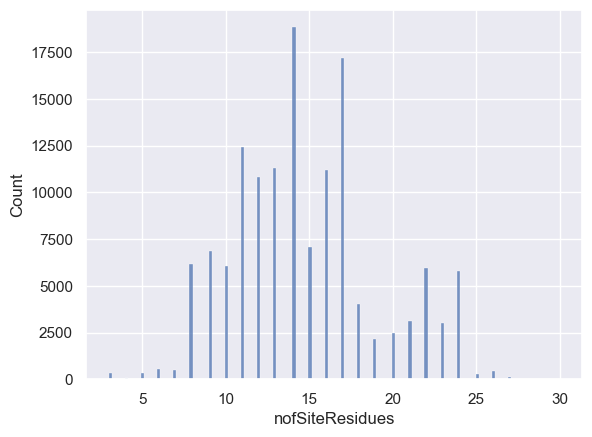

In [20]:
sns.set()

# sns.histplot(data=df, x='siteBackBoneRMSD', kde=False)
sns.histplot(data=df, x='nofSiteResidues', kde=False)

# df.hist('siteBackBoneRMSD', bins=100)
# df.hist('nofSiteResidues', bins=100)
# df_corrected_all.hist('alignmentLDDT', bins=100)
# df_corrected_all.hist('fullSeqId', bins=100)
# df_corrected_all_tmalign.hist('seqid', bins=100) # tmaligns seq id
# df_corrected_all_tmalign.hist('tm_score_max', bins=100)
# df_corrected_all.plot.scatter(x='siteBackBoneRMSD', y='fullSeqId')
# df_corrected_all_tmalign.plot.scatter(x='siteBackBoneRMSD', y='tm_score_max')
# df_corrected_all_tmalign.plot.scatter(x='siteBackBoneRMSD', y='tm_score_max')

In [21]:
unique_proteins = len(df['queryName'].unique())
unique_query_sites = df.drop_duplicates(subset=['queryName', 'queryChain', 'queryPos', 'queryAA']).shape[0]
unique_site_pairs = df.drop_duplicates(subset=['queryName', 'queryChain', 'queryPos', 'queryAA', 'hitName', 'hitChain', 'hitPos', 'hitAA']).shape[0]
print(f'We found hits in the PDB for ${unique_proteins}$ unique wild-type proteins from the evaluation mutation data sets.'
      f' In total, we found ${unique_site_pairs}$ similar environment hits for ${unique_query_sites}$ query micro-environments.')
# df_all.dropna().drop_duplicates(subset=['queryName', 'queryChain', 'queryPos', 'queryAA']).shape[0]
# print(f'From these hits {} are annotated with a mutant by the data sets')

We found hits in the PDB for $121$ unique wild-type proteins from the evaluation mutation data sets. In total, we found $137325$ similar environment hits for $3343$ query micro-environments.


In [22]:
df_all.isna().any(axis=1).sum() 

238

In [23]:
df_corrected_all.isna().any(axis=1).sum() 

0

In [24]:
df_all[df_all.isna().any(axis=1)]

queryName queryAA queryChain queryPos hitName hitAA hitChain hitPos   
14        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN  \
54        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
71        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
72        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
75        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
..        ...     ...        ...      ...     ...   ...      ...    ...   
425       NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
426       NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
12        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
74        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   
82        NaN     NaN        NaN      NaN     NaN   NaN      NaN    NaN   

     siteIdentity  siteBackBoneRMSD  siteAllAtomRMSD  nofSiteResidues   
14            NaN               NaN              NaN              NaN  \
54            NaN               NaN              NaN              NaN   
71            NaN               NaN              NaN              NaN   
72            NaN               NaN              NaN              NaN   
75            NaN               NaN              NaN              NaN   
..            ...               ...              ...              ...   
425           NaN               NaN              NaN              NaN   
426           NaN               NaN              NaN              NaN   
12            NaN               NaN              NaN              NaN   
74            NaN               NaN              NaN              NaN   
82            NaN               NaN              NaN              NaN   

     alignmentLDDT  fullSeqId         dataset  
14             NaN        NaN        protherm  
54             NaN        NaN        protherm  
71             NaN        NaN        protherm  
72             NaN        NaN        protherm  
75             NaN        NaN        protherm  
..             ...        ...             ...  
425            NaN        NaN     thermomutdb  
426            NaN        NaN     thermomutdb  
12             NaN        NaN  shanthirabalan  
74             NaN        NaN  shanthirabalan  
82             NaN        NaN  shanthirabalan  

[238 rows x 15 columns]

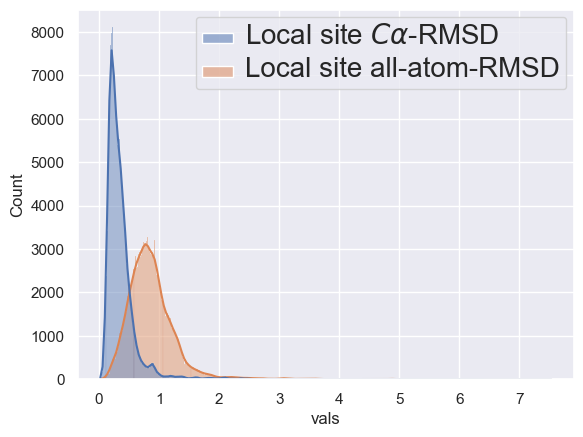

In [25]:
df_rmsd = pd.DataFrame({'vals': np.hstack((df['siteBackBoneRMSD'].values, df['siteAllAtomRMSD'].values)),
             'RMSD': [r'Local site $C\alpha$-RMSD'] * df.shape[0] + [r'Local site all-atom-RMSD'] * df.shape[0]})
ax = sns.histplot(data=df_rmsd, x='vals', kde=True, hue='RMSD')
ax.legend_.set_title(None)
ax.legend_.get_texts()[0].set_fontsize(20)
ax.legend_.get_texts()[1].set_fontsize(20)

nofResidues	>0.5	<0.5	odds	
0	0	0	nan	
1	0	0	nan	
2	331	26	12.73	
3	28	65	0.43	
4	234	108	2.17	
5	362	206	1.76	
6	489	19	25.74	
7	6140	31	198.06	
8	6874	1	6874.00	
9	6078	1	6078.00	
10	12445	0	inf	
11	10818	0	inf	
12	11325	0	inf	
13	18832	0	inf	
14	7074	0	inf	
15	11206	0	inf	
16	17212	0	inf	
17	4017	0	inf	
18	2155	0	inf	
19	2482	0	inf	
20	3094	0	inf	
21	5956	0	inf	
22	3027	0	inf	
23	5792	0	inf	
24	292	0	inf	
25	432	0	inf	
26	136	0	inf	
27	26	0	inf	
28	4	0	inf	
29	7	0	inf	



/tmp/ipykernel_31409/4040138860.py:11: RuntimeWarning: invalid value encountered in long_scalars
  f'{(nof_greater / (_df_i.shape[0] - nof_greater)):.2f}', '\n'])
/tmp/ipykernel_31409/4040138860.py:11: RuntimeWarning: divide by zero encountered in long_scalars
  f'{(nof_greater / (_df_i.shape[0] - nof_greater)):.2f}', '\n'])


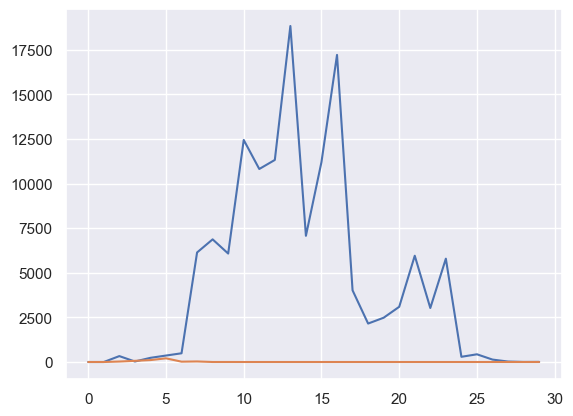

In [26]:
counts_arr = np.empty((2, df_tmalign['nofSiteResidues'].max()), dtype=int)
sizes = np.arange(df_tmalign['nofSiteResidues'].max())
fp_str = '\t'.join(['nofResidues', '>0.5', '<0.5', 'odds', '\n'])
for i in sizes:
    resNum = i + 1
    _df_i = df_tmalign.query('nofSiteResidues == @resNum')
    nof_greater = (_df_i['tm_score_max'] > 0.5).sum()
    counts_arr[0, i] = nof_greater
    counts_arr[1, i] = _df_i.shape[0] - nof_greater
    fp_str += '\t'.join([f'{i}', f'{nof_greater}', f'{_df_i.shape[0] - nof_greater}',
                         f'{(nof_greater / (_df_i.shape[0] - nof_greater)):.2f}', '\n'])
_df_i = None
print(fp_str)
with open(plots_outdir / 'fp_str.csv', 'w') as f:
    f.write(fp_str)

plt.plot(sizes, counts_arr[0])
plt.plot(sizes, counts_arr[1])

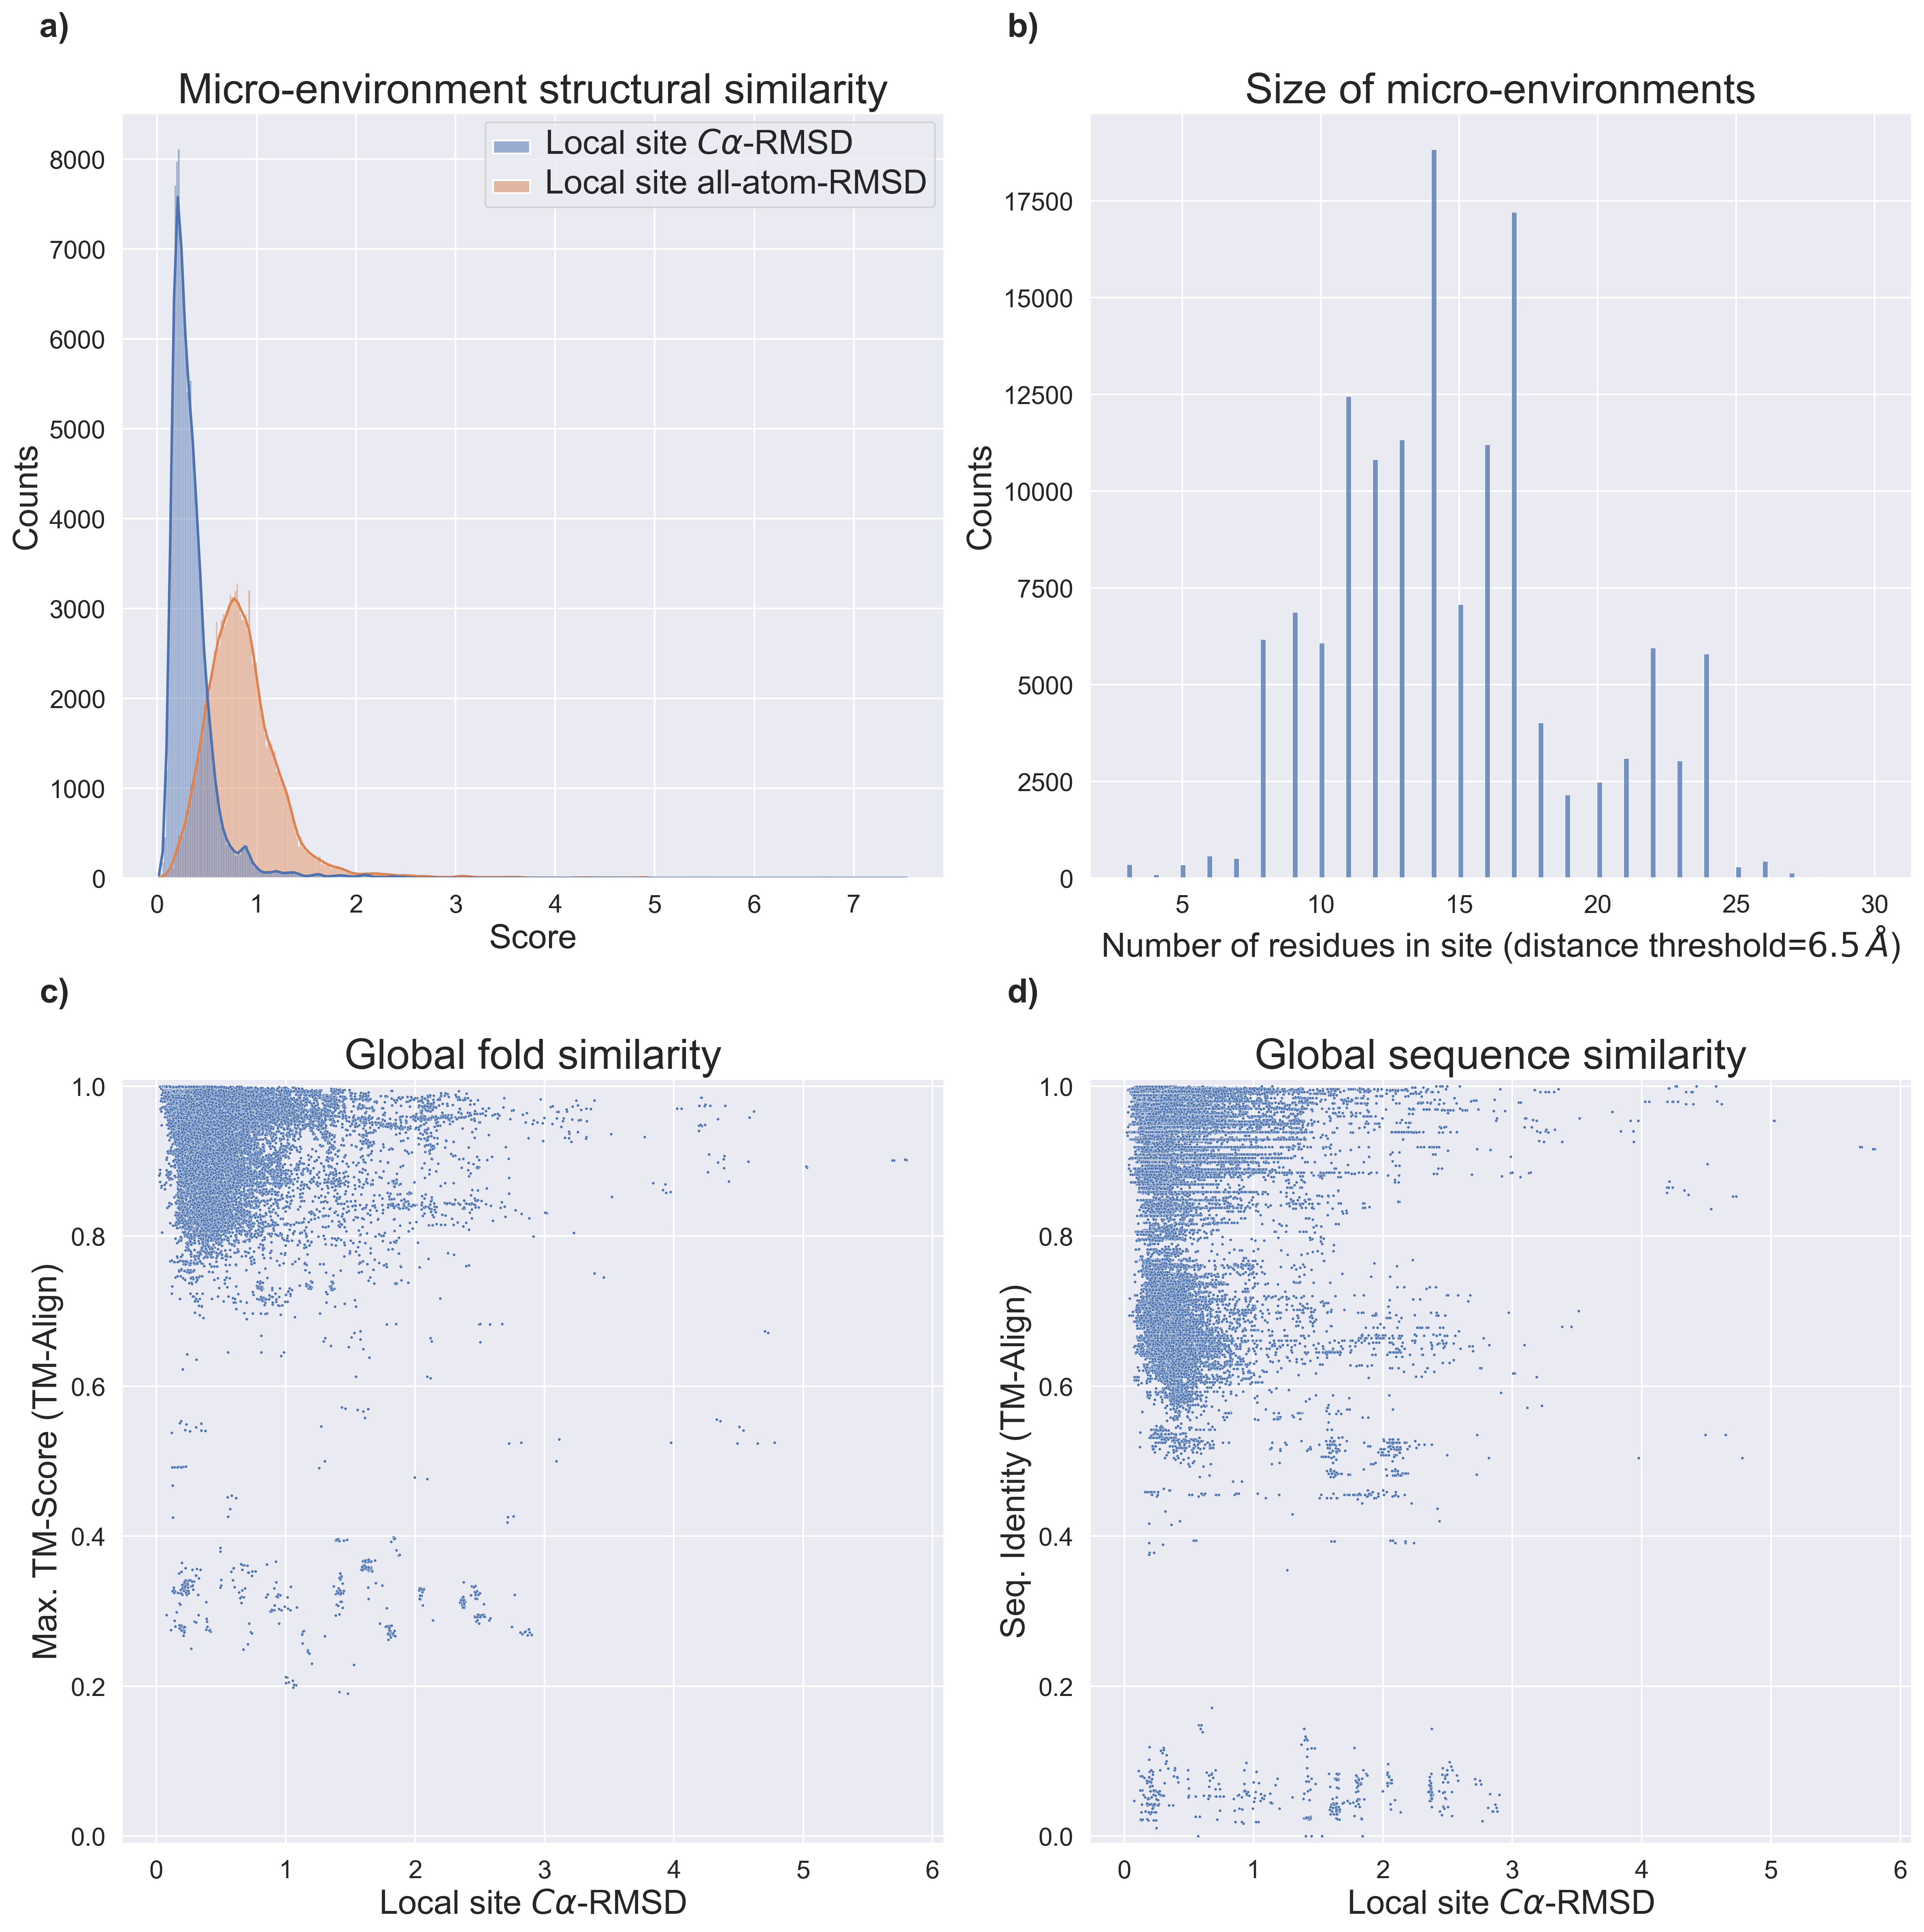

In [27]:
sns.set()
palette = sns.color_palette()

df_scatter = df_tmalign

# plt.figure())
fig, axs = plt.subplots(2, 2, figsize=(16, 16), sharey=False, sharex=False,  dpi=300)
subplot_title_size = 25
tick_size = 15
x_label_size = 20
y_label_size = 20


ax0, ax1, ax2, ax3 = axs.flatten()


# sns.histplot(data=df_rmsd, x='vals', kde=True, ax=ax0, hue='RMSD')
sns.histplot(data=df_rmsd, x='vals', kde=True, ax=ax0, hue='RMSD')
ax0.legend_.set_title(None)
ax0.legend_.get_texts()[0].set_fontsize(20)
ax0.legend_.get_texts()[1].set_fontsize(20)
ax0.set_xlabel(r'Score', fontsize=x_label_size)
ax0.set_ylabel('Counts', fontsize=y_label_size)
ax0.set_title('Micro-environment structural similarity', fontsize=subplot_title_size)

sns.histplot(data=df, x='nofSiteResidues', kde=False, ax=ax1)
ax1.set_xlabel(r'Number of residues in site (distance threshold=$6.5\,\AA$)', fontsize=x_label_size)
ax1.set_ylabel('Counts', fontsize=y_label_size)
ax1.set_title('Size of micro-environments', fontsize=subplot_title_size)

sns.scatterplot(data=df_scatter, x='siteBackBoneRMSD', y='tm_score_max', ax=ax2, s=3)
ax2.set_xlabel(r'Local site $C\alpha$-RMSD', fontsize=x_label_size)
ax2.set_ylabel('Max. TM-Score (TM-Align)', fontsize=y_label_size)
ax2.set_title('Global fold similarity', fontsize=subplot_title_size)
ax2.set_ylim([-0.01, 1.01])

sns.scatterplot(data=df_scatter, x='siteBackBoneRMSD', y='seqid', ax=ax3, s=3)
ax3.set_xlabel(r'Local site $C\alpha$-RMSD', fontsize=x_label_size)
ax3.set_ylabel('Seq. Identity (TM-Align)', fontsize=y_label_size)
ax3.set_title('Global sequence similarity', fontsize=subplot_title_size)
ax3.set_ylim([-0.01, 1.01])

for n, ax in enumerate(axs.flatten()):
    # set size of ticks
    ax.tick_params(labelsize=tick_size)

    # add a), b), c) etc
    ax.text(-0.1, 1.1, string.ascii_lowercase[n] + ')', transform=ax.transAxes, size=20, weight='bold')

plt.tight_layout()
plt.savefig(plots_outdir / 'site_flex_sim.png', dpi=600)

In [28]:
df_scatter.query('nofSiteResidues < 7 and tm_score_max > 0.5').value_counts('nofSiteResidues')

nofSiteResidues
6    362
3    331
5    234
4     28
Name: count, dtype: int64

In [29]:
df_scatter['wild_pdb'].unique().__len__()

121

In [30]:
nof_hits_per_query = df_scatter.groupby(['queryName']).size()

<Axes: >

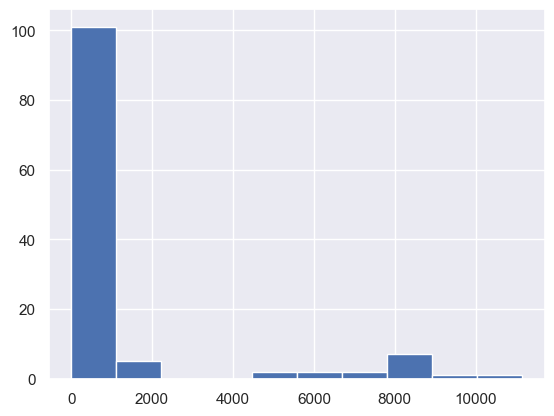

In [31]:
nof_hits_per_query.hist()

In [32]:
df["siteAllAtomRMSD"].sort_values().dropna()

498    0.075
17     0.075
185    0.082
184    0.084
232    0.086
       ...  
25     7.385
22     7.460
26     7.476
19     7.512
21     7.531
Name: siteAllAtomRMSD, Length: 137289, dtype: float64

In [33]:
# plot some numbers for the subplots above
nof_hits_per_query = df_scatter.groupby(['queryName']).size()


ci_siteBackBoneRMSD_mean = bootstrap((df["siteBackBoneRMSD"].values,), np.mean, batch=256, confidence_level=0.95)
ci_siteAllAtomRMSD_mean = bootstrap((df["siteAllAtomRMSD"].dropna().values,), np.mean, batch=256, confidence_level=0.95)
ci_nofSiteResidues_mean = bootstrap((df["nofSiteResidues"].values,), np.mean, batch=256, confidence_level=0.95)
ci_tm_score_max_mean = bootstrap((df_scatter["tm_score_max"].values,), np.mean, batch=256, confidence_level=0.95)
ci_seqid_mean = bootstrap((df_scatter["seqid"].values,), np.mean, batch=256, confidence_level=0.95)
ci_nof_hits_per_query_mean = bootstrap((nof_hits_per_query.values,), np.mean, batch=256, confidence_level=0.95)

print(f'ci_siteBackBoneRMSD_mean: {ci_siteBackBoneRMSD_mean.confidence_interval.low:.2f}-{ci_siteBackBoneRMSD_mean.confidence_interval.high:.2f}')
print(f'ci_siteAllAtomRMSD_mean: {ci_siteAllAtomRMSD_mean.confidence_interval.low:.2f}-{ci_siteAllAtomRMSD_mean.confidence_interval.high:.2f}')
print(f'ci_nofSiteResidues_mean: {ci_nofSiteResidues_mean.confidence_interval.low:.2f}-{ci_nofSiteResidues_mean.confidence_interval.high:.2f}')
print(f'ci_tm_score_max_mean: {ci_tm_score_max_mean.confidence_interval.low:.2f}-{ci_tm_score_max_mean.confidence_interval.high:.2f}')
print(f'ci_seqid_mean: {ci_seqid_mean.confidence_interval.low:.2f}-{ci_seqid_mean.confidence_interval.high:.2f}')
print(f'ci_nof_hits_per_query_mean: {ci_nof_hits_per_query_mean.confidence_interval.low:.2f}-{ci_nof_hits_per_query_mean.confidence_interval.high:.2f}')


print(f'Local Calpha RMSD mean={df["siteBackBoneRMSD"].mean():.2f} median={df["siteBackBoneRMSD"].median():.2f} std={df["siteBackBoneRMSD"].std():.2f}')
print(f'Local all-atom RMSD mean={df["siteAllAtomRMSD"].dropna().mean():.2f} median={df["siteAllAtomRMSD"].dropna().median():.2f} std={df["siteAllAtomRMSD"].dropna().std():.2f}')
print(f'NumOf residues in mean={df["nofSiteResidues"].mean():.2f} median={df["nofSiteResidues"].median():.2f} std={df["nofSiteResidues"].std():.2f}')
print(f'Max TM-SCore in mean={df_scatter["tm_score_max"].mean():.2f} median={df_scatter["tm_score_max"].median():.2f} std={df_scatter["tm_score_max"].std():.2f}')
print(f'SeqID in mean={df_scatter["seqid"].mean():.2f} median={df_scatter["seqid"].median():.2f} std={df_scatter["seqid"].std():.2f}')
print(f'nof_hits_per_query in mean={nof_hits_per_query.mean():.2f} median={nof_hits_per_query.median():.2f} std={nof_hits_per_query.std():.2f}')

ci_siteBackBoneRMSD_mean: 0.35-0.36
ci_siteAllAtomRMSD_mean: 0.87-0.88
ci_nofSiteResidues_mean: 14.75-14.80
ci_tm_score_max_mean: 0.97-0.97
ci_seqid_mean: 0.91-0.91
ci_nof_hits_per_query_mean: 757.87-1665.48
Local Calpha RMSD mean=0.36 median=0.29 std=0.27
Local all-atom RMSD mean=0.87 median=0.81 std=0.44
NumOf residues in mean=14.77 median=14.00 std=4.37
Max TM-SCore in mean=0.97 median=0.98 std=0.05
SeqID in mean=0.91 median=0.94 std=0.10
nof_hits_per_query in mean=1134.92 median=136.00 std=2504.00


In [34]:
print(f"${df_scatter.query('tm_score_max <= 0.5').shape[0] / df_scatter.shape[0] * 100:.2f}$\% of hits have a max TM-Score $<0.5$")

$0.33$\% of hits have a max TM-Score $<0.5$


In [35]:
df_scatter.shape[0], df_scatter.query('tm_score_max <=0.5').shape[0],\
df_scatter.query('nofSiteResidues >= 7').shape[0], df_scatter.query('nofSiteResidues >= 7 and tm_score_max <=0.5').shape[0]

(137325, 457, 135965, 52)

In [36]:
max_rmsd = 10
backboneRMSDscore = (max_rmsd - np.minimum(df_scatter['siteBackBoneRMSD'], max_rmsd)) / max_rmsd
allatomRMSDscore = (max_rmsd - np.minimum(df_scatter['siteAllAtomRMSD'], max_rmsd)) / max_rmsd

In [37]:
df_scatter['localGlobalScore'] =  (df_scatter['fullSeqId'] + df_scatter['alignmentLDDT'])/2 * df_scatter['nofSiteResidues']
# df_scatter['localGlobalScore'] =  (0.007 * df_scatter['fullSeqId'] + 0.003 * df_scatter['alignmentLDDT'] + 0.99 * (df_scatter['nofSiteResidues'] / 300)**10)
df_scatter['localGlobalScore'] =  (0.7 * df_scatter['fullSeqId'] + 0.3 * df_scatter['alignmentLDDT']) * df_scatter['nofSiteResidues']

# from sklearn.metrics import roc_auc_score, average_precision_score
# print(f"roc localGlobalScore {roc_auc_score(df_scatter['tm_score_max'] > 0.5, df_scatter['localGlobalScore']):.4f}")
# print(f"roc nofResidue       {roc_auc_score(df_scatter['tm_score_max'] > 0.5, df_scatter['nofSiteResidues']):.4f}")
# print(f"roc nofResidue>=7    {roc_auc_score(df_scatter['tm_score_max'] > 0.5, df_scatter['nofSiteResidues'] >= 7):.4f}")

# print(f"pr localGlobalScore {average_precision_score(df_scatter['tm_score_max'] > 0.5, df_scatter['localGlobalScore']):.4f}")
# print(f"pr nofResidue       {average_precision_score(df_scatter['tm_score_max'] > 0.5, df_scatter['nofSiteResidues']):.4f}")
# print(f"pr nofResidue>=7    {average_precision_score(df_scatter['tm_score_max'] > 0.5, df_scatter['nofSiteResidues'] >= 7):.4f}")

# df_sub = df_scatter.query('nofSiteResidues <= 10')
# print(f"roc localGlobalScore {roc_auc_score(df_sub['tm_score_max'] > 0.5, df_sub['localGlobalScore']):.4f}")
# print(f"roc nofResidue       {roc_auc_score(df_sub['tm_score_max'] > 0.5, df_sub['nofSiteResidues']):.4f}")
# print(f"roc nofResidue>=7    {roc_auc_score(df_sub['tm_score_max'] > 0.5, df_sub['nofSiteResidues'] >= 7):.4f}")

# print(f"pr localGlobalScore {average_precision_score(df_sub['tm_score_max'] > 0.5, df_sub['localGlobalScore']):.4f}")
# print(f"pr nofResidue       {average_precision_score(df_sub['tm_score_max'] > 0.5, df_sub['nofSiteResidues']):.4f}")
# print(f"pr nofResidue>=7    {average_precision_score(df_sub['tm_score_max'] > 0.5, df_sub['nofSiteResidues'] >= 7):.4f}")

roc localGlobalScore 0.9975
roc nofResidue       0.9931
roc nofResidue>=7    0.9396
pr localGlobalScore 1.0000
pr nofResidue       1.0000
pr nofResidue>=7    0.9996
roc localGlobalScore 0.9837
roc nofResidue       0.9543
roc nofResidue>=7    0.9199
pr localGlobalScore 0.9996
pr nofResidue       0.9985
pr nofResidue>=7    0.9965


In [38]:
threshold = 3.5

print('Nof all hits', df_scatter.shape[0], 'FPs (no filter)', df_scatter.query('tm_score_max <=0.5').shape[0])
print(df_scatter.query('nofSiteResidues >= 7').shape[0], df_scatter.query('nofSiteResidues >= 7 and tm_score_max <=0.5').shape[0])
print(df_scatter.query('localGlobalScore >= @threshold').shape[0], df_scatter.query('localGlobalScore >= @threshold and tm_score_max <=0.5').shape[0])


Nof all hits 137325 FPs (no filter) 457
135965 52
136389 5


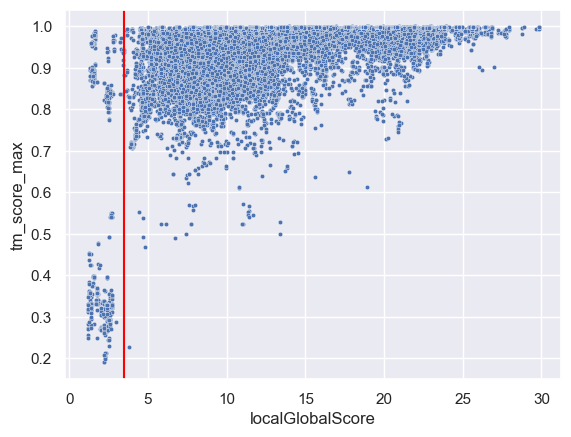

In [39]:
sns.scatterplot(data=df_scatter, x='localGlobalScore', y='tm_score_max', s=10)
plt.axvline(threshold, 0, 1.0, color='red')

<Axes: xlabel='nofSiteResidues', ylabel='tm_score_max'>

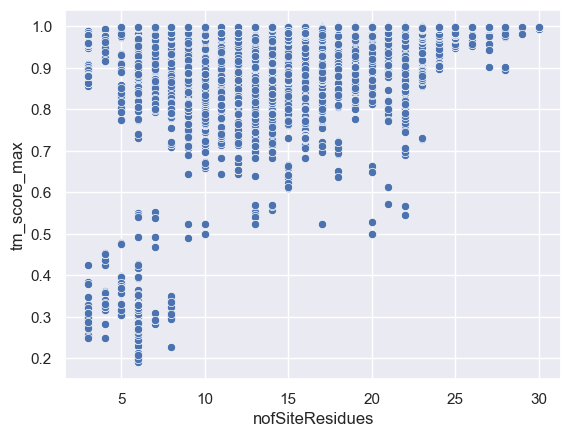

In [40]:
sns.scatterplot(data=df_scatter, x='nofSiteResidues', y='tm_score_max')

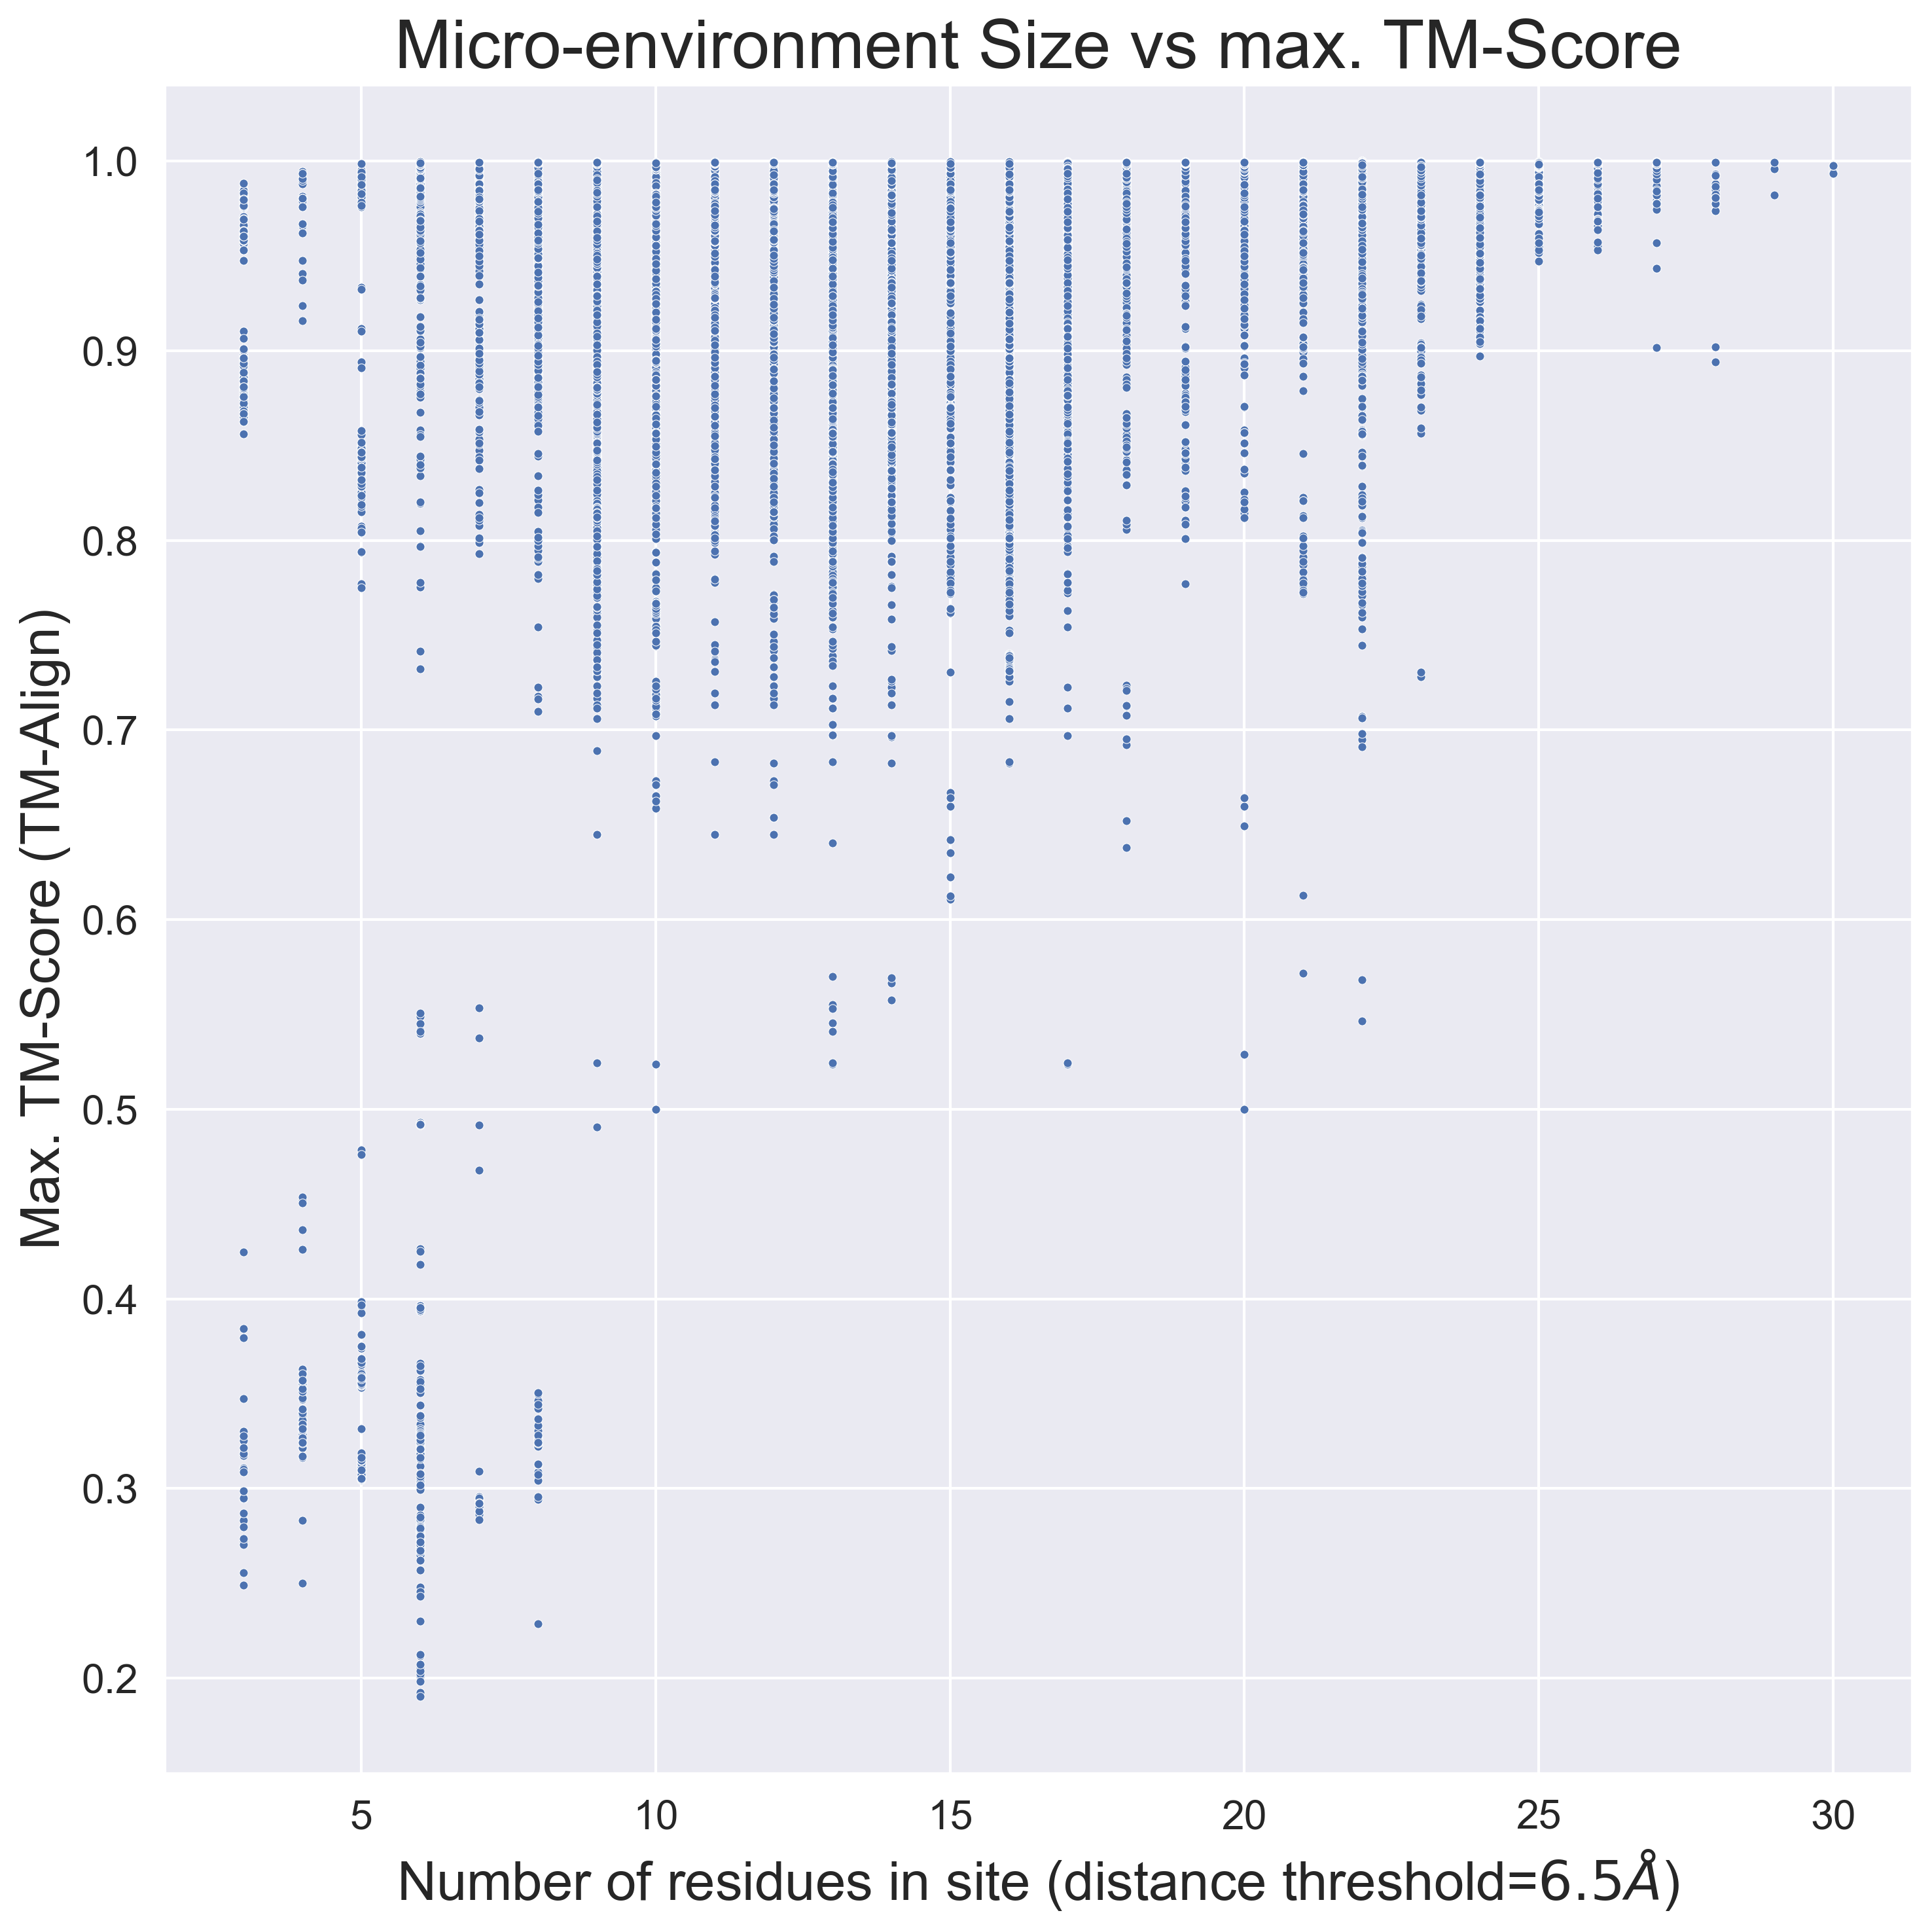

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharey=False, sharex=False,  dpi=300)
subplot_title_size = 25
tick_size = 15
x_label_size = 20
y_label_size = 20

sns.scatterplot(data=df_scatter, x='nofSiteResidues', y='tm_score_max',  ax=ax, s=10)
# sns.boxplot(data=df_scatter, x='nofSiteResidues', y='tm_score_max', ax=ax)
ax.set_ylabel('Max. TM-Score (TM-Align)', fontsize=y_label_size)
ax.set_xlabel(r'Number of residues in site (distance threshold=$6.5 \AA$)', fontsize=x_label_size)

ax.set_title('Micro-environment Size vs max. TM-Score', fontsize=subplot_title_size)

# set size of ticks
ax.tick_params(labelsize=tick_size)

plt.tight_layout()
plt.savefig(plots_outdir / 'tmscore_vs_sitesize.png', dpi=300)


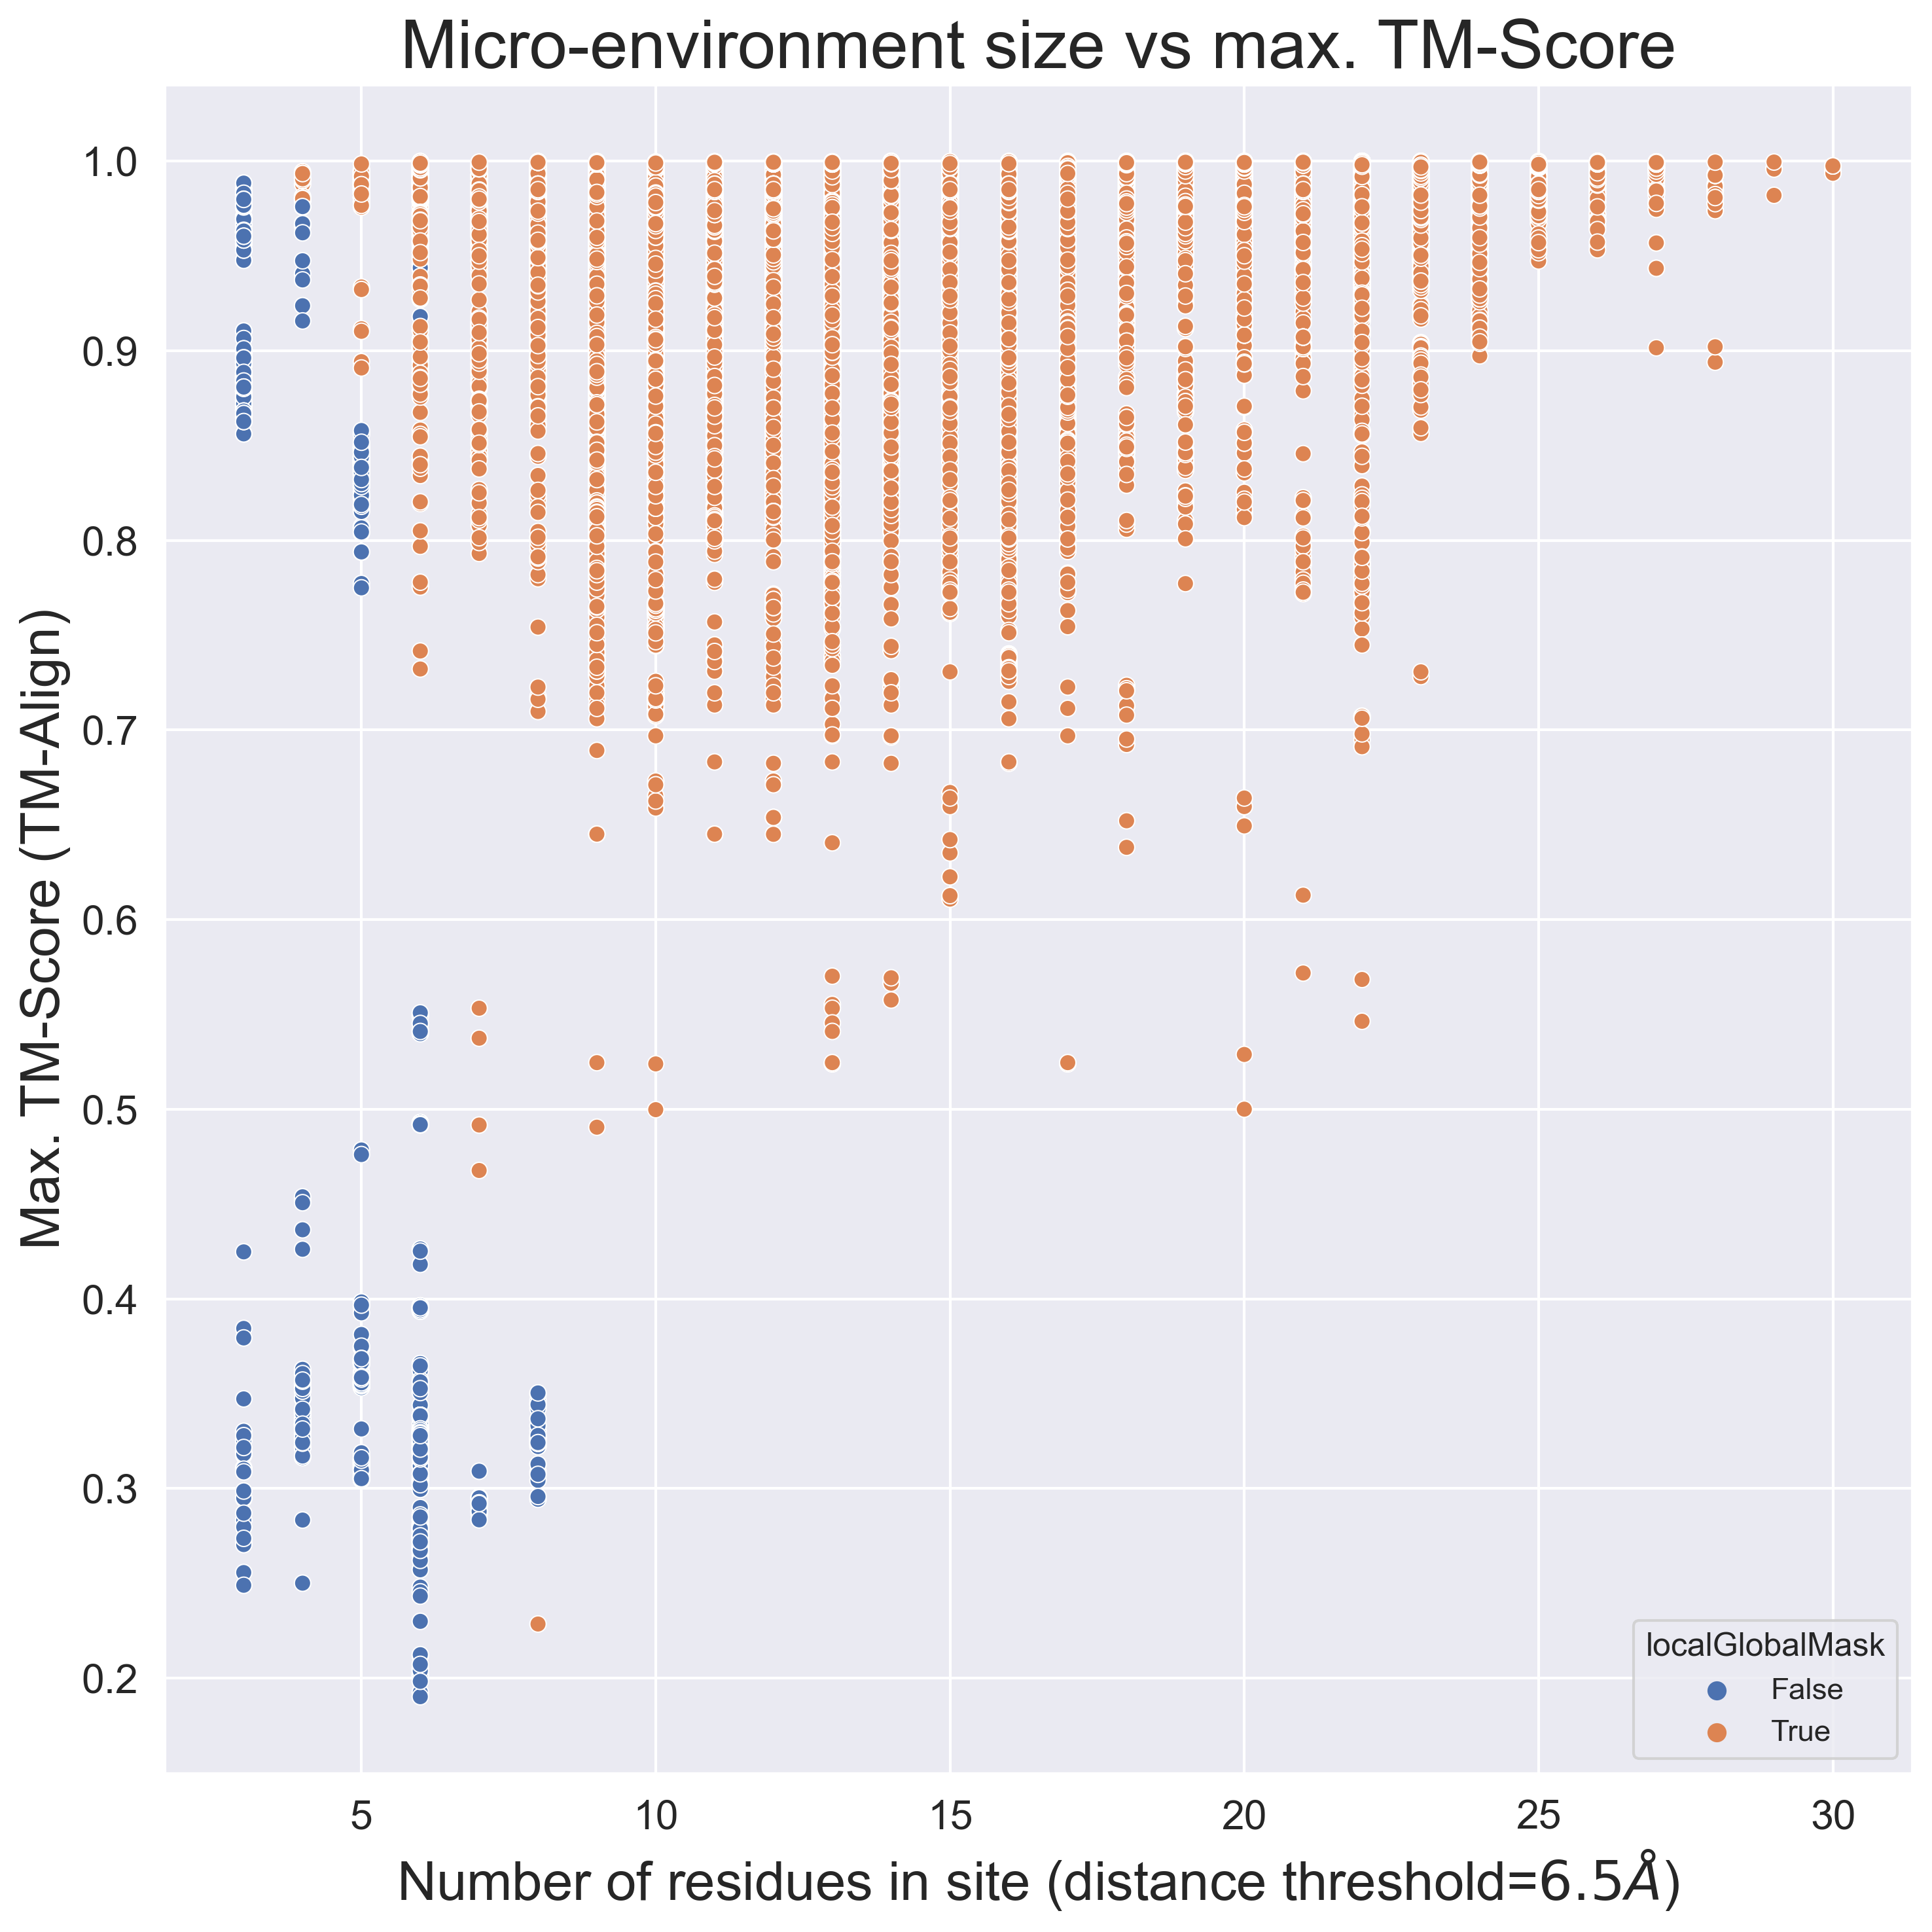

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharey=False, sharex=False,  dpi=300)
subplot_title_size = 25
tick_size = 15
x_label_size = 20
y_label_size = 20

df_scatter['localGlobalMask'] =  df_scatter['localGlobalScore'] > threshold

sns.scatterplot(data=df_scatter, x='nofSiteResidues', y='tm_score_max',  ax=ax, hue='localGlobalMask')
# sns.boxplot(data=df_scatter, x='nofSiteResidues', y='tm_score_max', ax=ax)
ax.set_ylabel('Max. TM-Score (TM-Align)', fontsize=y_label_size)
ax.set_xlabel(r'Number of residues in site (distance threshold=$6.5 \AA$)', fontsize=x_label_size)

ax.set_title('Micro-environment size vs max. TM-Score', fontsize=subplot_title_size)

# set size of ticks
ax.tick_params(labelsize=tick_size)

plt.tight_layout()
plt.savefig(plots_outdir / 'site_flex_sim_tmscore_size.png', dpi=300)


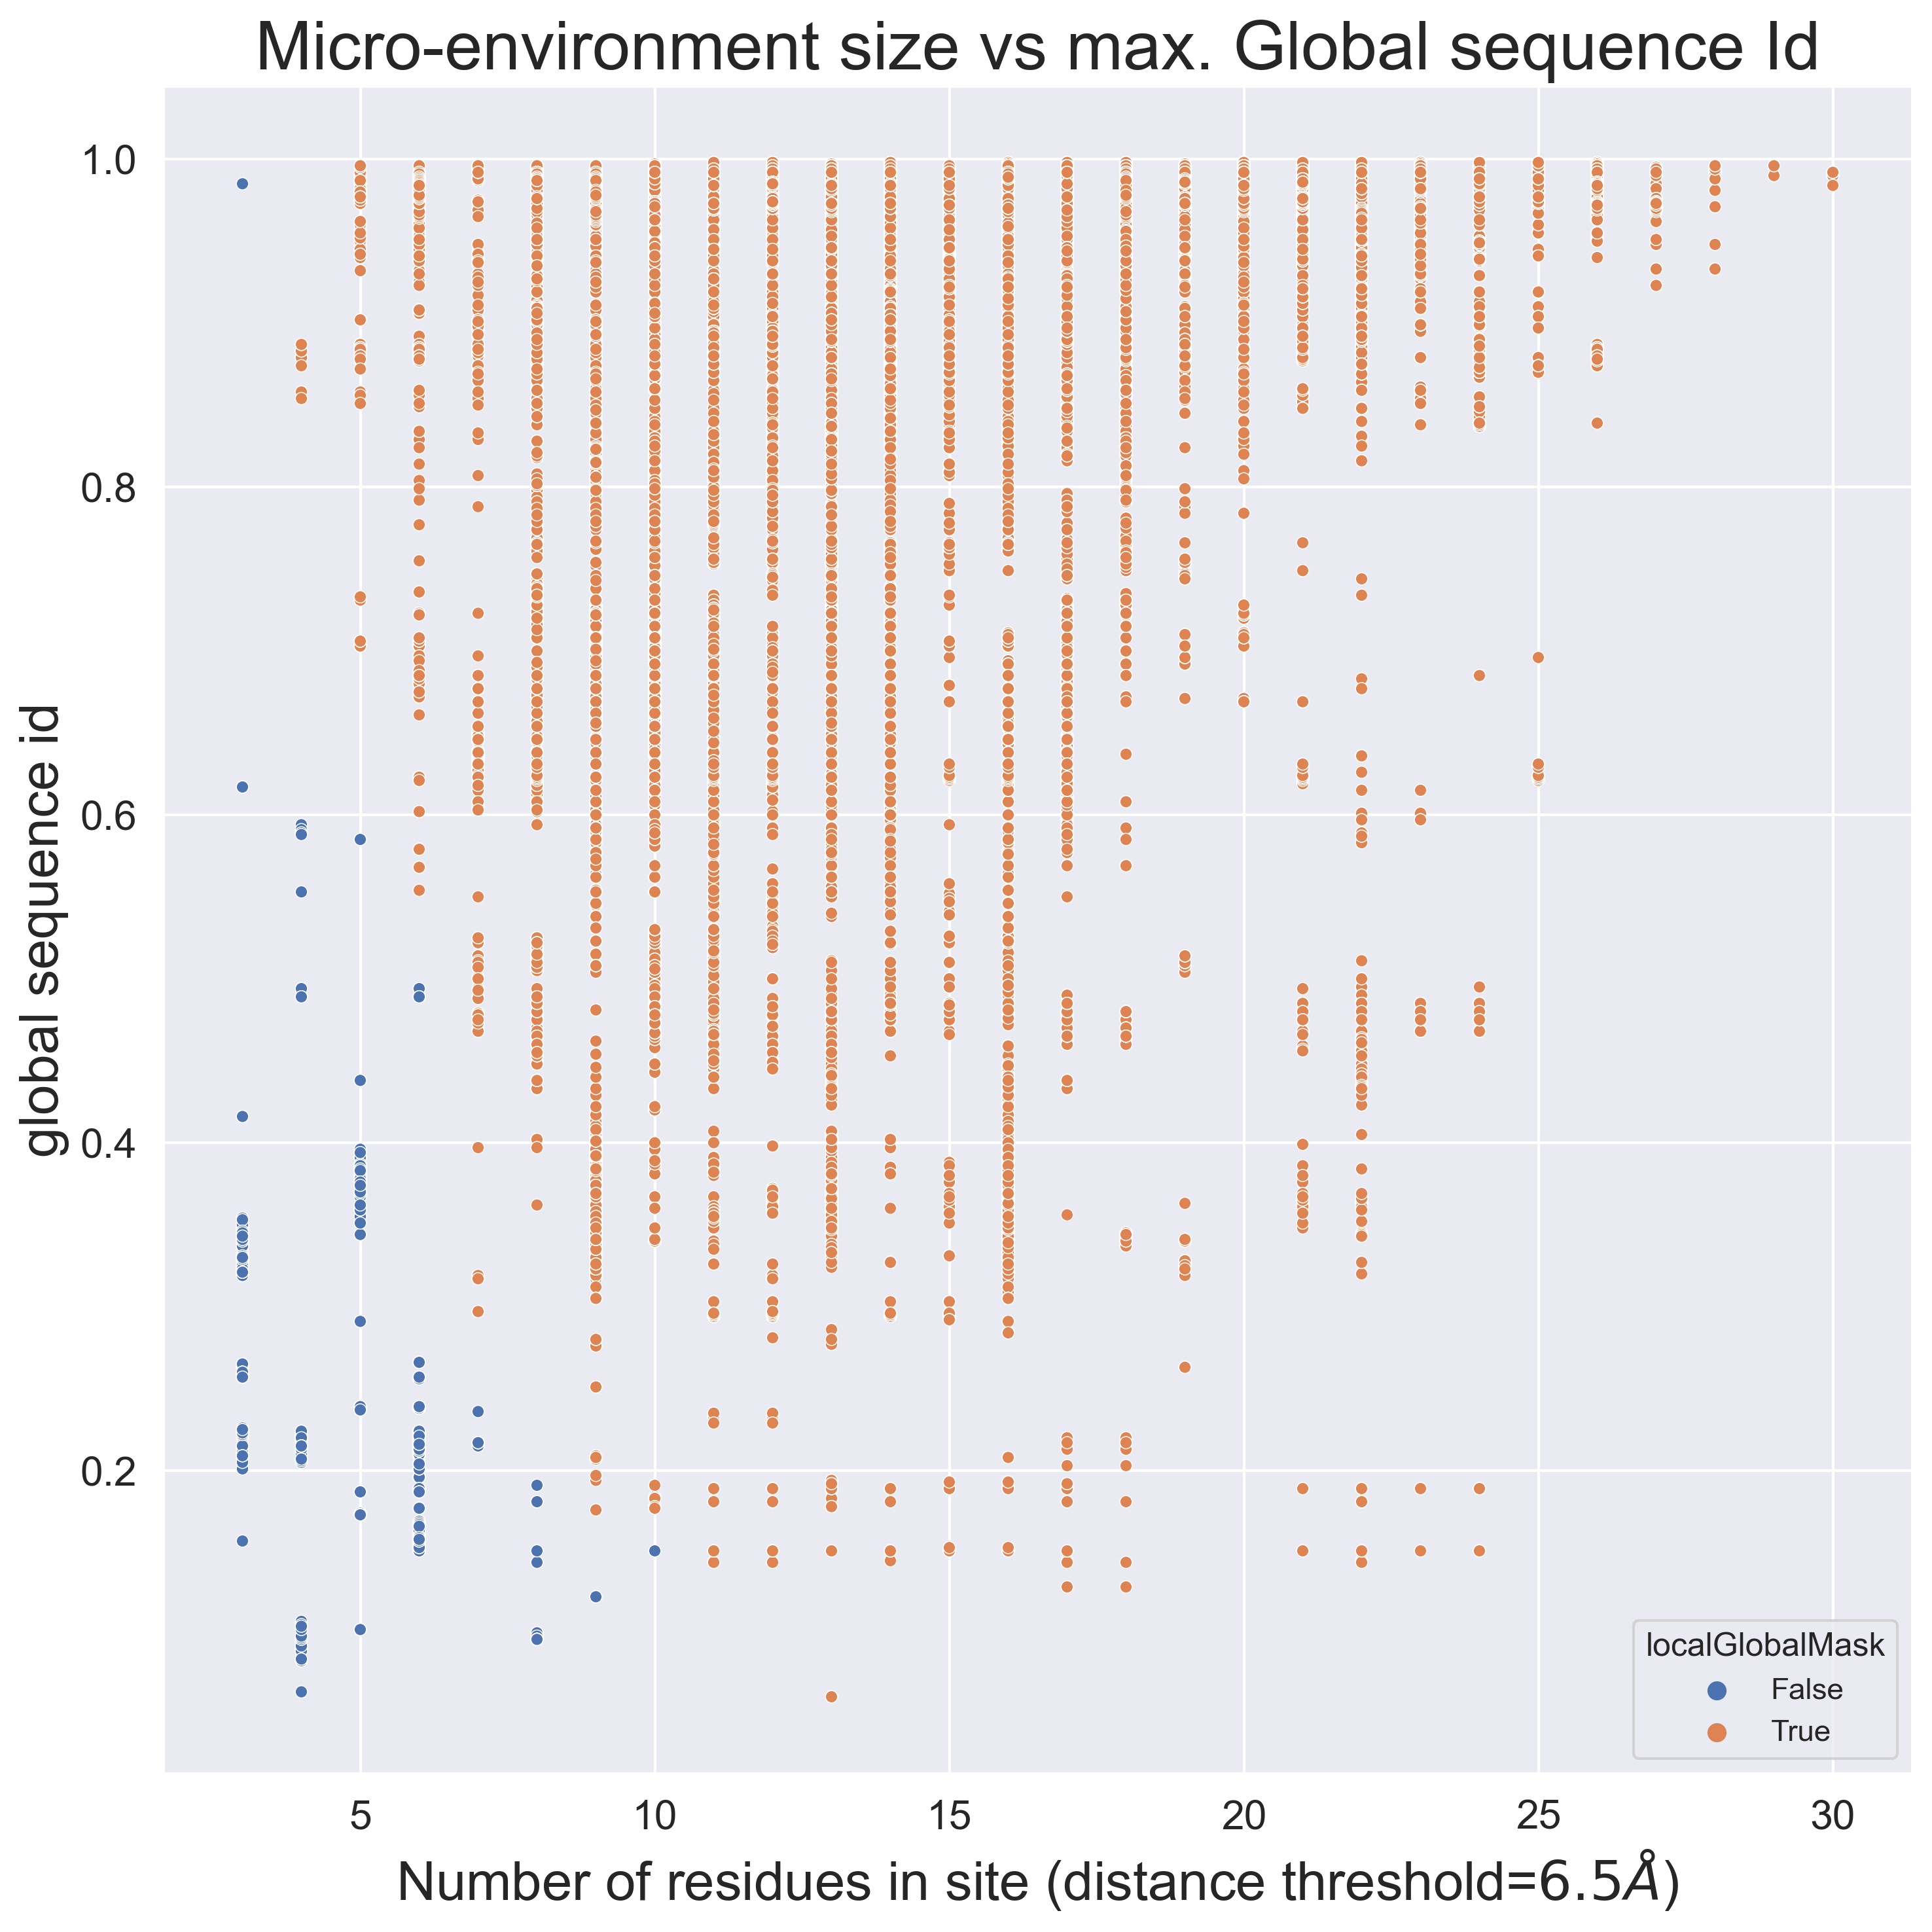

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharey=False, sharex=False,  dpi=300)
subplot_title_size = 25
tick_size = 15
x_label_size = 20
y_label_size = 20

sns.scatterplot(data=df_scatter, x='nofSiteResidues', y='fullSeqId', s=20,  ax=ax, hue='localGlobalMask')
# sns.boxplot(data=df_scatter, x='nofSiteResidues', y='tm_score_max', ax=ax)
ax.set_ylabel('global sequence id', fontsize=y_label_size)
ax.set_xlabel(r'Number of residues in site (distance threshold=$6.5 \AA$)', fontsize=x_label_size)

ax.set_title('Micro-environment size vs max. Global sequence Id', fontsize=subplot_title_size)

# set size of ticks
ax.tick_params(labelsize=tick_size)

plt.tight_layout()
plt.savefig(plots_outdir / 'site_flex_sim_fullseqid_size.png', dpi=300)

In [44]:
df_scatter['tm_score_mask'] = df_scatter['tm_score_max'].apply(lambda x: "TM-Score > 0.5" if x > 0.5 else "TM-Score <= 0.5")

df_counts = pd.DataFrame([df_scatter['nofSiteResidues'].value_counts().rename('siteCount'),
                          df_scatter.query('tm_score_mask == "TM-Score > 0.5"')['nofSiteResidues'].value_counts().rename('TM-Score > 0.5'),
                          df_scatter.query('tm_score_mask == "TM-Score <= 0.5"')['nofSiteResidues'].value_counts().rename('TM-Score <= 0.5')
                         ])
df_counts = df_counts.T.reset_index()
# df_counts['nofSiteResidues'] = df_counts['index']
df_counts

nofSiteResidues  siteCount  TM-Score > 0.5  TM-Score <= 0.5
0                14    18832.0         18832.0              NaN
1                17    17212.0         17212.0              NaN
2                11    12445.0         12445.0              NaN
3                13    11325.0         11325.0              NaN
4                16    11206.0         11206.0              NaN
5                12    10818.0         10818.0              NaN
6                15     7074.0          7074.0              NaN
7                 9     6875.0          6874.0              1.0
8                 8     6171.0          6140.0             31.0
9                10     6079.0          6078.0              1.0
10               22     5956.0          5956.0              NaN
11               24     5792.0          5792.0              NaN
12               18     4017.0          4017.0              NaN
13               21     3094.0          3094.0              NaN
14               23     3027.0          3027.0              NaN
15               20     2482.0          2482.0              NaN
16               19     2155.0          2155.0              NaN
17                6      568.0           362.0            206.0
18                7      508.0           489.0             19.0
19               26      432.0           432.0              NaN
20                3      357.0           331.0             26.0
21                5      342.0           234.0            108.0
22               25      292.0           292.0              NaN
23               27      136.0           136.0              NaN
24                4       93.0            28.0             65.0
25               28       26.0            26.0              NaN
26               30        7.0             7.0              NaN
27               29        4.0             4.0              NaN

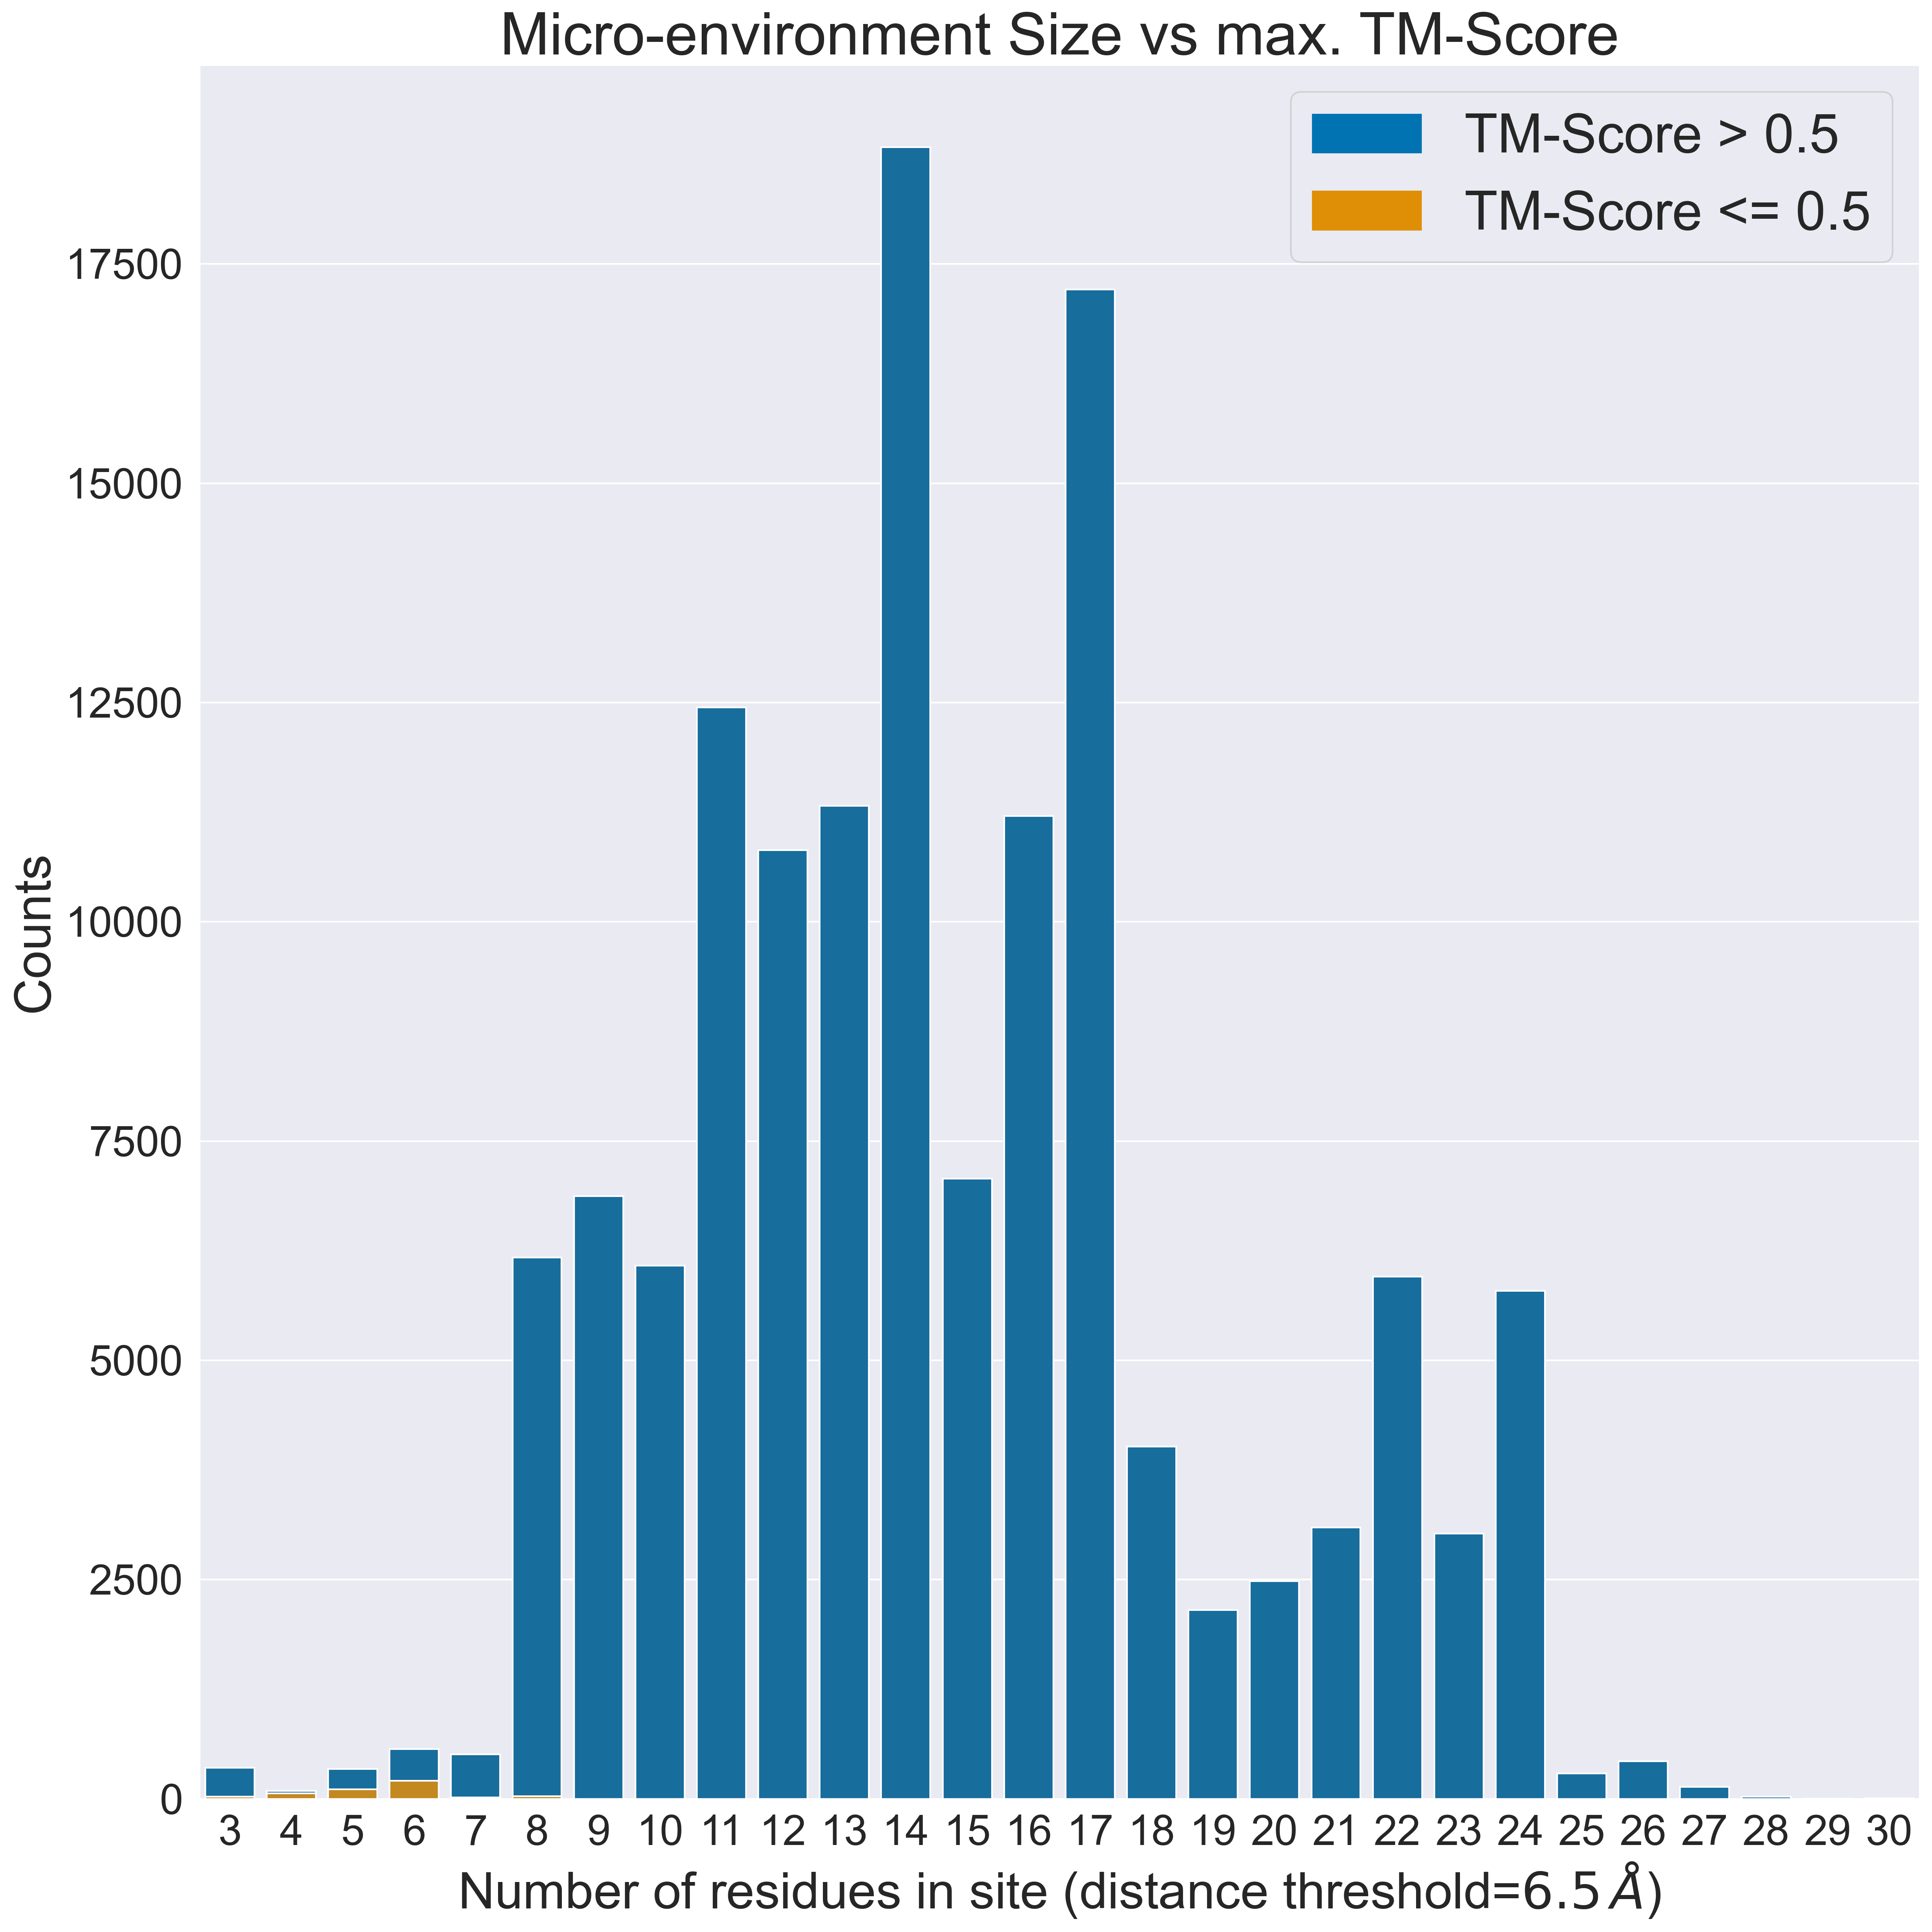

In [45]:
sns.set()

pal = sns.color_palette('colorblind').as_hex()
pal

fig, ax = plt.subplots(1, 1, figsize=(16, 16), sharey=False, sharex=False,  dpi=300)
plus = 10
subplot_title_size = 25 + plus
tick_size = 15+ plus
x_label_size = 20+ plus
y_label_size = 20+ plus
legend_font_size = 22 + plus

sns.barplot(data=df_counts, x='nofSiteResidues', y='siteCount', color=pal[0], ax=ax)
sns.barplot(data=df_counts, x='nofSiteResidues', y='TM-Score <= 0.5', color=pal[1], ax=ax)

ax.set_ylabel('Counts', fontsize=y_label_size)
ax.set_xlabel(r'Number of residues in site (distance threshold=$6.5\,\AA$)', fontsize=x_label_size)
patches = [matplotlib.patches.Patch(color=pal[0], label='TM-Score > 0.5'),
           matplotlib.patches.Patch(color=pal[1], label='TM-Score <= 0.5'),
          ]
plt.legend(handles=patches, fontsize=legend_font_size, loc="upper right")   

ax.set_title('Micro-environment Size vs max. TM-Score', fontsize=subplot_title_size)

ax.tick_params(labelsize=tick_size)

plt.tight_layout()
plt.savefig(plots_outdir / 'site_flex_sim_tmscore_size_bar.png', dpi=300)

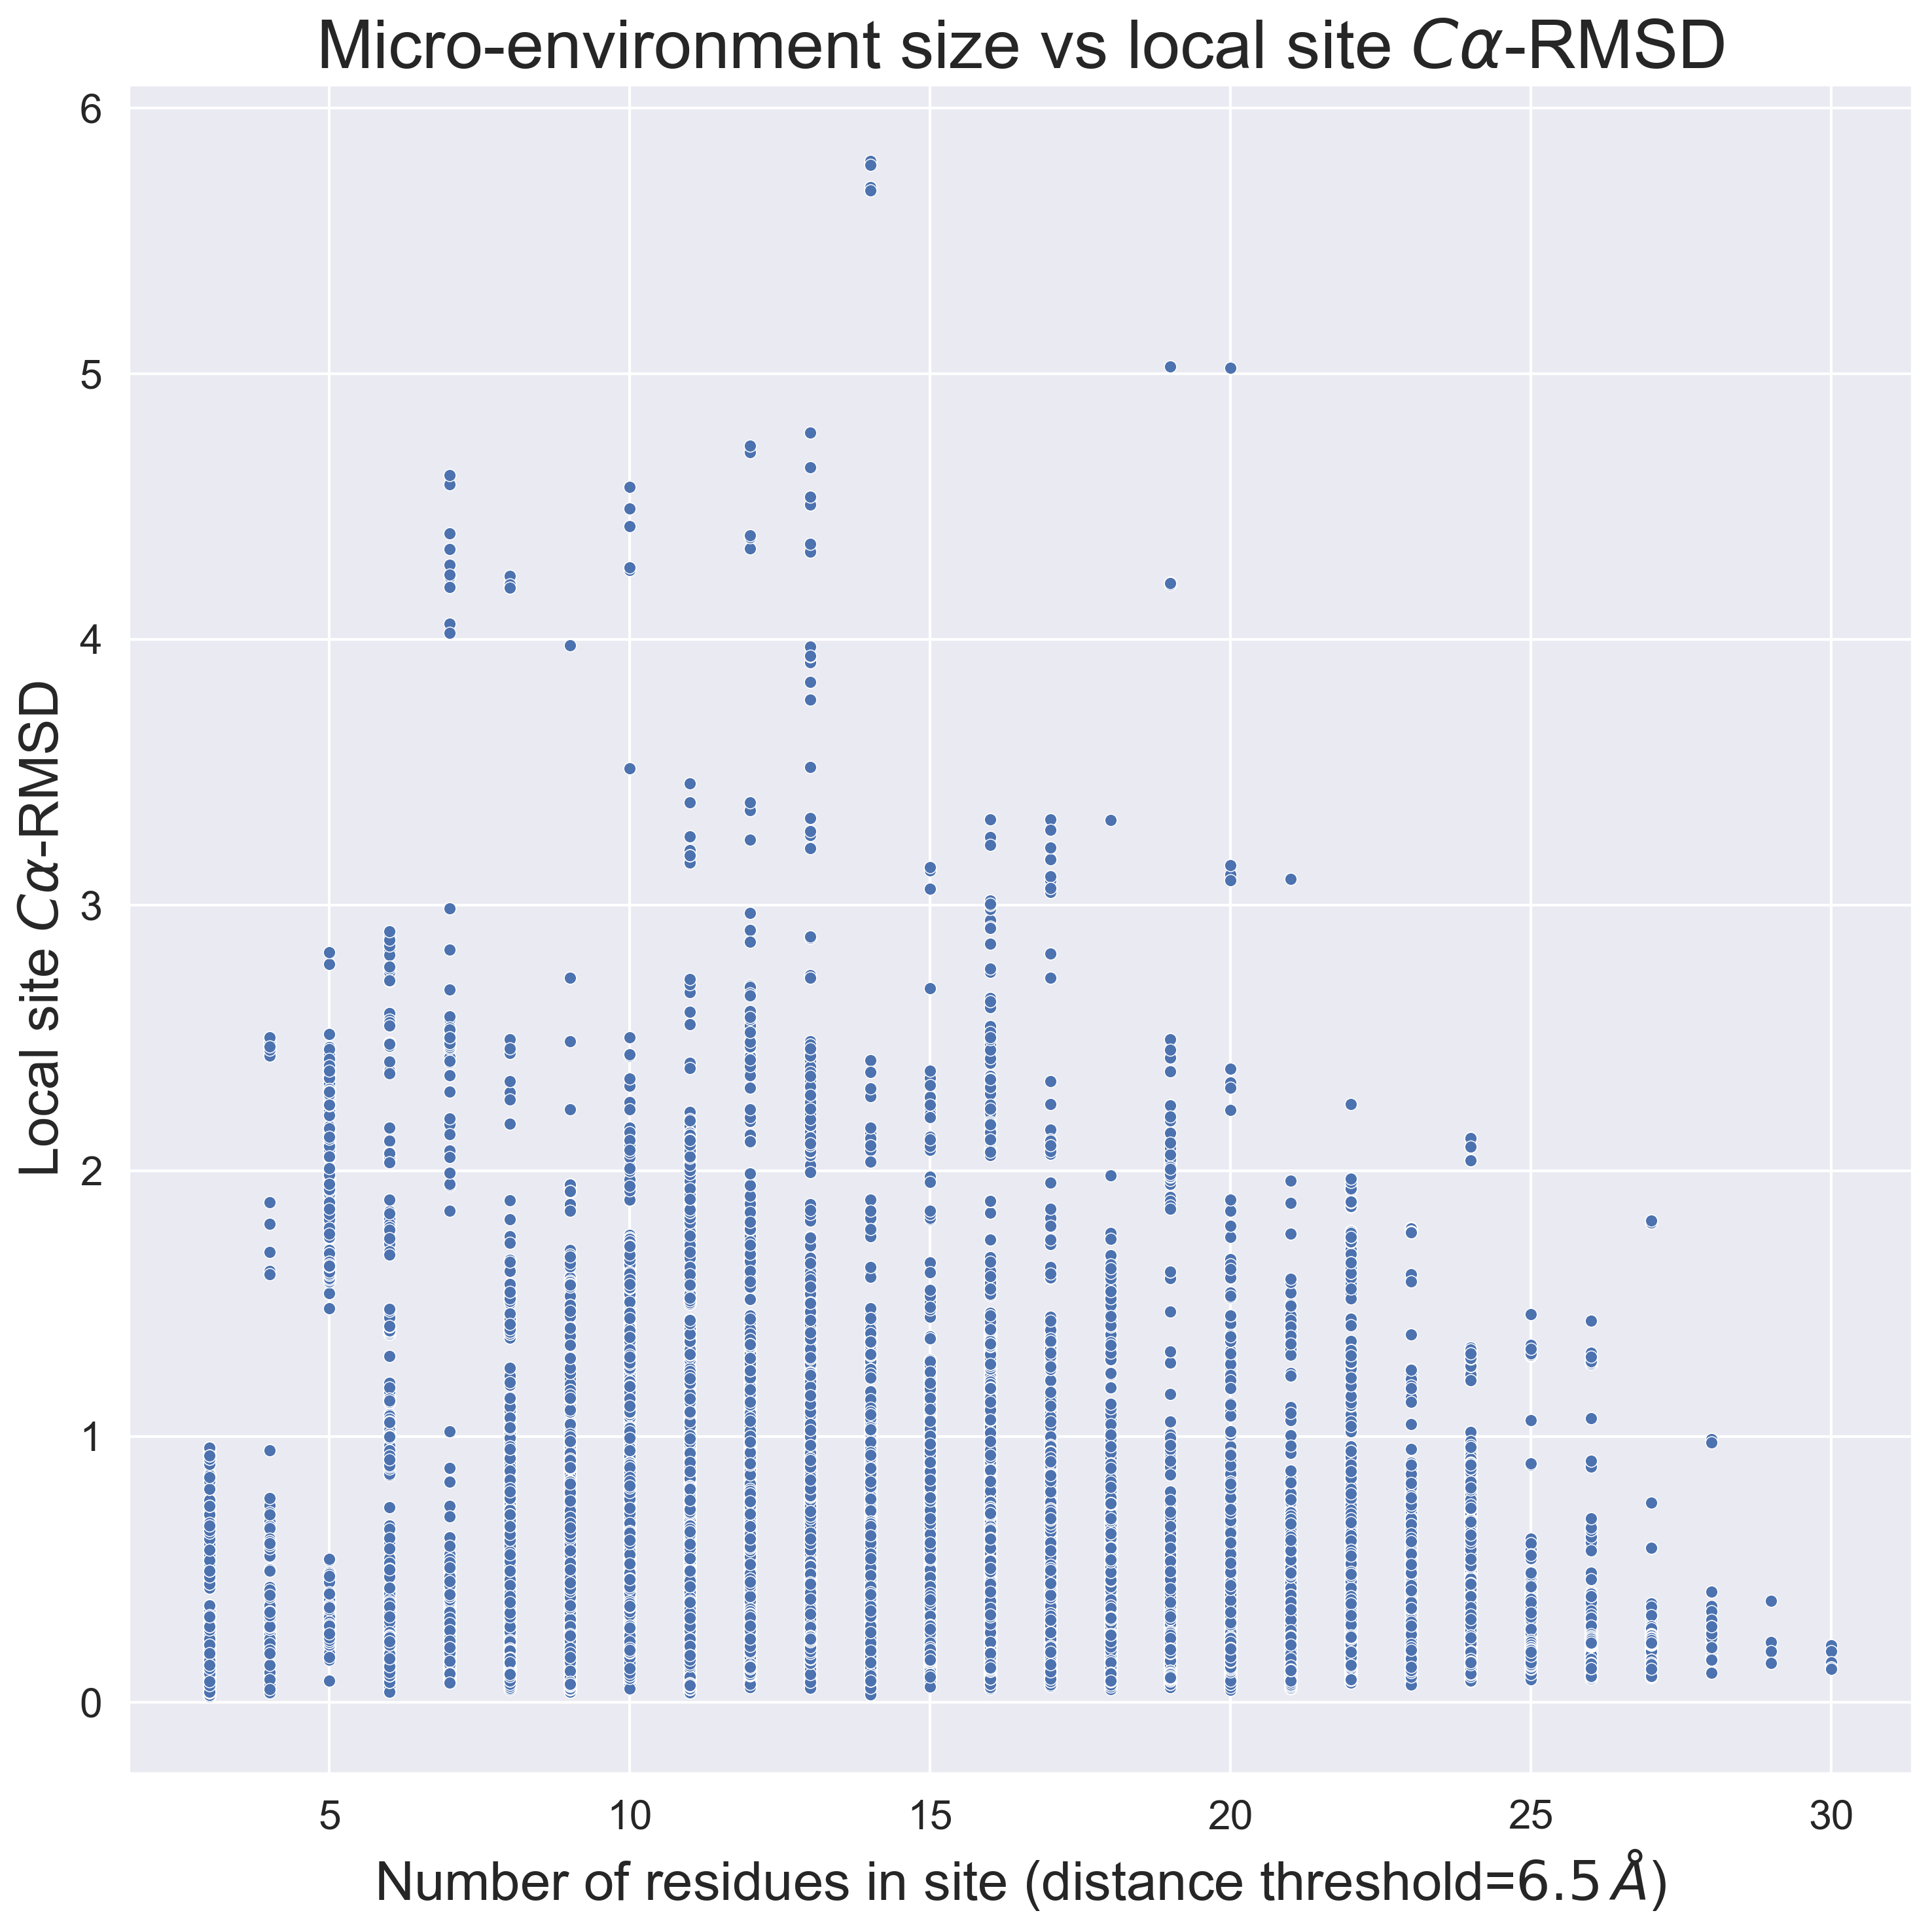

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharey=False, sharex=False,  dpi=300)
subplot_title_size = 25
tick_size = 15
x_label_size = 20
y_label_size = 20

sns.scatterplot(data=df_scatter, x='nofSiteResidues', y='siteBackBoneRMSD', s=20,  ax=ax)
# sns.boxplot(data=df_scatter, x='nofSiteResidues', y='tm_score_max', ax=ax)
ax.set_ylabel(r'Local site $C\alpha$-RMSD', fontsize=y_label_size)
ax.set_xlabel(r'Number of residues in site (distance threshold=$6.5\,\AA$)', fontsize=x_label_size)

ax.set_title(r'Micro-environment size vs local site $C\alpha$-RMSD', fontsize=subplot_title_size)

# set size of ticks
ax.tick_params(labelsize=tick_size)

plt.tight_layout()
plt.savefig(plots_outdir / 'site_flex_sim_siteBackBoneRMSD_size.png', dpi=300)

<Axes: xlabel='nofSiteResidues', ylabel='siteAllAtomRMSD'>

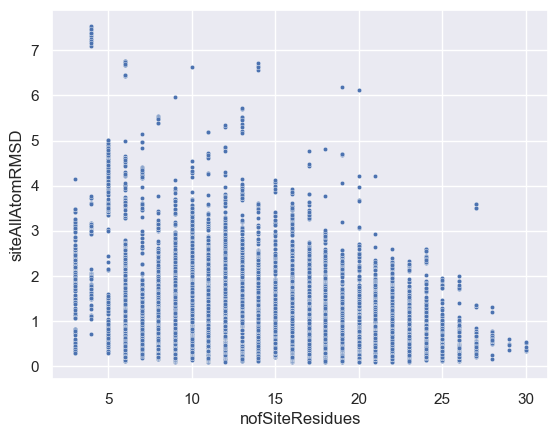

In [47]:
sns.scatterplot(data=df_scatter, x='nofSiteResidues', y='siteAllAtomRMSD',
#                 label="TM-Score (max)",
                s=10, color=palette[0])

<Axes: xlabel='tm_score_max', ylabel='siteBackBoneRMSD'>

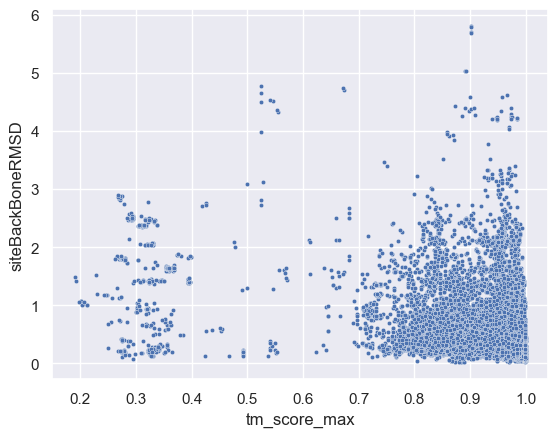

In [48]:
sns.scatterplot(data=df_scatter, x='tm_score_max', y='siteBackBoneRMSD',
#                 label="TM-Score (max)",
                s=10, color=palette[0])

<Axes: xlabel='tm_score_max', ylabel='siteAllAtomRMSD'>

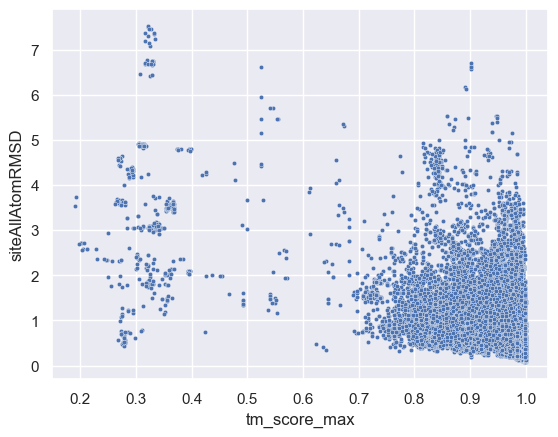

In [49]:
sns.scatterplot(data=df_scatter, x='tm_score_max', y='siteAllAtomRMSD',
#                 label="TM-Score (max)",
                s=10, color=palette[0])

In [50]:
df_scatter.sort_values('seqid').dropna()

chain_id1 chain_id2  chain1_len  chain2_len  align_len  rmsd  seqid   
2964           A         A          53         417         40  3.96    0.0  \
4096           A         A          62         535         41  3.62    0.0   
4092           A         A          62         527         40  3.68    0.0   
2781           A         A          58          22         13  2.31    0.0   
4146           A         B          45         407         36  3.41    0.0   
...          ...       ...         ...         ...        ...   ...    ...   
123021         E         D          44          90         43  0.61    1.0   
134463         C         A         524         524        523  0.28    1.0   
607            A         A         136         134        134  0.72    1.0   
121454         A         A         136         134        134  0.68    1.0   
118809         B         D         200         193        193  0.39    1.0   

        tm_score1  tm_score2 wild_pdb  ... nofSiteResidues alignmentLDDT   
2964      0.39674    0.07844     1ARR  ...               5         0.800  \
4096      0.32587    0.06543     1SSO  ...               8         0.839   
4092      0.32675    0.06472     1SSO  ...               8         0.830   
2781      0.14638    0.22858     1BPI  ...               8         0.732   
4146      0.43645    0.07631     1W3D  ...               4         0.833   
...           ...        ...      ...  ...             ...           ...   
123021    0.90589    0.46400     3MON  ...               6         0.750   
134463    0.99690    0.99690     5DEI  ...              11         0.995   
607       0.96551    0.97968     1STN  ...              21         0.964   
121454    0.96889    0.98316     1EY0  ...              21         0.993   
118809    0.95986    0.99450     2XWR  ...              13         0.994   

       fullSeqId         dataset query_mirror hit_mirror tm_score_max   
2964       0.103        protherm     standard   standard      0.39674  \
4096       0.097        protherm     standard   standard      0.32587   
4092       0.099        protherm     standard   standard      0.32675   
2781       0.362        protherm     standard   standard      0.22858   
4146       0.093        protherm     standard   standard      0.43645   
...          ...             ...          ...        ...          ...   
123021     0.489     thermomutdb     standard   standard      0.90589   
134463     0.996  shanthirabalan     standard   standard      0.99690   
607        0.985        protherm     standard   standard      0.97968   
121454     0.985     thermomutdb     standard   standard      0.98316   
118809     0.965     thermomutdb     standard   standard      0.99450   

       localGlobalScore localGlobalMask    tm_score_mask  
2964             1.5605           False  TM-Score <= 0.5  
4096             2.5568           False  TM-Score <= 0.5  
4092             2.5464           False  TM-Score <= 0.5  
2781             3.7840            True  TM-Score <= 0.5  
4146             1.2600           False  TM-Score <= 0.5  
...                 ...             ...              ...  
123021           3.4038           False   TM-Score > 0.5  
134463          10.9527            True   TM-Score > 0.5  
607             20.5527            True   TM-Score > 0.5  
121454          20.7354            True   TM-Score > 0.5  
118809          12.6581            True   TM-Score > 0.5  

[137289 rows x 34 columns]

In [52]:
df_f = df_scatter.query('tm_score_max < 0.5')
print(list(zip(df_f['queryName'], df_f['hitName'])))
df_f

[('1BPI', '1K09'), ('1ARR', '4Q6M'), ('1ARR', '4Q6N'), ('1ARR', '4Q6O'), ('1ARR', '4Q6P'), ('1ARR', '4Q6Q'), ('1ARR', '4Q6M'), ('1ARR', '4Q6N'), ('1ARR', '4Q6O'), ('1ARR', '4Q6P'), ('1ARR', '4Q6Q'), ('1SSO', '1HX9'), ('1SSO', '1HXA'), ('1SSO', '1HXC'), ('1SSO', '1HXG'), ('1SSO', '3LZ9'), ('1SSO', '3M00'), ('1SSO', '3M01'), ('1SSO', '3M02'), ('1SSO', '4DI5'), ('1SSO', '4RNQ'), ('1SSO', '5DHI'), ('1SSO', '5DHK'), ('1SSO', '5EAS'), ('1SSO', '5EAT'), ('1SSO', '5EAU'), ('1SSO', '5IK0'), ('1SSO', '5IK6'), ('1SSO', '5IK9'), ('1SSO', '5IKA'), ('1SSO', '5IKH'), ('1SSO', '5IL3'), ('1SSO', '5IL8'), ('1SSO', '5ILD'), ('1SSO', '5ILH'), ('1SSO', '5ILI'), ('1SSO', '5ILJ'), ('1SSO', '5ILK'), ('1SSO', '5ILY'), ('1SSO', '5ILZ'), ('1SSO', '5IM1'), ('1W3D', '1JS3'), ('1W3D', '1JS3'), ('1W3D', '1JS6'), ('1W3D', '1JS6'), ('1W3D', '3G25'), ('1W3D', '3G25'), ('1W3D', '3G25'), ('1W3D', '3G25'), ('1W3D', '3GE1'), ('1W3D', '3GE1'), ('1W3D', '3GE1'), ('1W3D', '3GE1'), ('1W3D', '3ZHC'), ('1W3D', '3ZHC'), ('1W3D', 

chain_id1 chain_id2  chain1_len  chain2_len  align_len  rmsd  seqid   
2781           A         A          58          22         13  2.31  0.000  \
2960           A         A          53         417         42  4.04  0.024   
2961           A         A          53         417         42  4.03  0.024   
2962           A         A          53         417         43  4.20  0.023   
2963           A         A          53         417         41  4.10  0.049   
...          ...       ...         ...         ...        ...   ...    ...   
137241         D         A         735         427        239  7.24  0.071   
137242         D         A         735         428        212  6.36  0.085   
137243         D         B         735         428        240  7.24  0.079   
137244         D         C         735         428        240  7.28  0.071   
137245         D         D         735         428        239  7.24  0.071   

        tm_score1  tm_score2 wild_pdb  ... nofSiteResidues alignmentLDDT   
2781      0.14638    0.22858     1BPI  ...               8         0.732  \
2960      0.39824    0.08150     1ARR  ...               5         0.800   
2961      0.39839    0.08153     1ARR  ...               5         0.775   
2962      0.39605    0.08241     1ARR  ...               5         0.775   
2963      0.39269    0.07951     1ARR  ...               5         0.800   
...           ...        ...      ...  ...             ...           ...   
137241    0.21974    0.32905     4BFL  ...               6         0.783   
137242    0.21011    0.32082     4BFL  ...               6         0.767   
137243    0.22047    0.32950     4BFL  ...               6         0.767   
137244    0.22013    0.32896     4BFL  ...               6         0.750   
137245    0.21949    0.32794     4BFL  ...               6         0.767   

       fullSeqId         dataset query_mirror hit_mirror tm_score_max   
2781       0.362        protherm     standard   standard      0.22858  \
2960       0.103        protherm     standard   standard      0.39824   
2961       0.103        protherm     standard   standard      0.39839   
2962       0.103        protherm     standard   standard      0.39605   
2963       0.103        protherm     standard   standard      0.39269   
...          ...             ...          ...        ...          ...   
137241     0.239  shanthirabalan     standard   standard      0.32905   
137242     0.239  shanthirabalan     standard   standard      0.32082   
137243     0.239  shanthirabalan     standard   standard      0.32950   
137244     0.239  shanthirabalan     standard   standard      0.32896   
137245     0.239  shanthirabalan     standard   standard      0.32794   

       localGlobalScore localGlobalMask    tm_score_mask  
2781             3.7840            True  TM-Score <= 0.5  
2960             1.5605           False  TM-Score <= 0.5  
2961             1.5230           False  TM-Score <= 0.5  
2962             1.5230           False  TM-Score <= 0.5  
2963             1.5605           False  TM-Score <= 0.5  
...                 ...             ...              ...  
137241           2.4132           False  TM-Score <= 0.5  
137242           2.3844           False  TM-Score <= 0.5  
137243           2.3844           False  TM-Score <= 0.5  
137244           2.3538           False  TM-Score <= 0.5  
137245           2.3844           False  TM-Score <= 0.5  

[457 rows x 34 columns]

In [53]:
with pd.option_context('display.max_columns', 100, 'display.max_rows', 100):
#     display(df_scatter.sort_values('tm_score_max').dropna().head(n=100))
    display(df_scatter.query('tm_score_max < 0.5').dropna())

chain_id1 chain_id2  chain1_len  chain2_len  align_len  rmsd  seqid   
2781           A         A          58          22         13  2.31  0.000  \
2960           A         A          53         417         42  4.04  0.024   
2961           A         A          53         417         42  4.03  0.024   
2962           A         A          53         417         43  4.20  0.023   
2963           A         A          53         417         41  4.10  0.049   
...          ...       ...         ...         ...        ...   ...    ...   
137241         D         A         735         427        239  7.24  0.071   
137242         D         A         735         428        212  6.36  0.085   
137243         D         B         735         428        240  7.24  0.079   
137244         D         C         735         428        240  7.28  0.071   
137245         D         D         735         428        239  7.24  0.071   

        tm_score1  tm_score2 wild_pdb mut_pdb   mirror1   mirror2 queryName   
2781      0.14638    0.22858     1BPI    1K09  standard  standard      1BPI  \
2960      0.39824    0.08150     1ARR    4Q6M  standard  standard      1ARR   
2961      0.39839    0.08153     1ARR    4Q6N  standard  standard      1ARR   
2962      0.39605    0.08241     1ARR    4Q6O  standard  standard      1ARR   
2963      0.39269    0.07951     1ARR    4Q6P  standard  standard      1ARR   
...           ...        ...      ...     ...       ...       ...       ...   
137241    0.21974    0.32905     4BFL    7KB0  standard  standard      4BFL   
137242    0.21011    0.32082     4BFL    7KB1  standard  standard      4BFL   
137243    0.22047    0.32950     4BFL    7KB1  standard  standard      4BFL   
137244    0.22013    0.32896     4BFL    7KB1  standard  standard      4BFL   
137245    0.21949    0.32794     4BFL    7KB1  standard  standard      4BFL   

       queryAA queryChain queryPos hitName hitAA hitChain hitPos   
2781       ALA          A       27    1K09   ASP        A     14  \
2960       GLN          A        9    4Q6M   LEU        A    283   
2961       GLN          A        9    4Q6N   LEU        A    283   
2962       GLN          A        9    4Q6O   LEU        A    283   
2963       GLN          A        9    4Q6P   LEU        A    283   
...        ...        ...      ...     ...   ...      ...    ...   
137241     VAL          D      494    7KB0   THR        A    328   
137242     VAL          D      494    7KB1   THR        A    328   
137243     VAL          D      494    7KB1   THR        B    328   
137244     VAL          D      494    7KB1   THR        C    328   
137245     VAL          D      494    7KB1   THR        D    328   

        siteIdentity  siteBackBoneRMSD  siteAllAtomRMSD  nofSiteResidues   
2781           0.875             1.528            2.581                8  \
2960           0.800             1.834            4.798                5   
2961           0.800             1.833            4.798                5   
2962           0.800             1.837            4.800                5   
2963           0.800             1.816            4.793                5   
...              ...               ...              ...              ...   
137241         0.833             2.060            6.443                6   
137242         0.833             2.037            6.686                6   
137243         0.833             2.045            6.759                6   
137244         0.833             2.066            6.750                6   
137245         0.833             2.032            6.699                6   

        alignmentLDDT  fullSeqId         dataset query_mirror hit_mirror   
2781            0.732      0.362        protherm     standard   standard  \
2960            0.800      0.103        protherm     standard   standard   
2961            0.775      0.103        protherm     standard   standard   
2962            0.775      0.103        protherm     standard   standard   
2963       

In [54]:
df_scatter.query('tm_score_max <= 0.5').sort_values(['queryName', 'hitName', 'queryChain', 'queryPos', 'tm_score_max'])[
    ['queryName' ,'queryAA','queryChain','queryPos', 'hitName','hitAA','hitChain','hitPos', 'tm_score_max', 'fullSeqId', 'nofSiteResidues', 
     'siteBackBoneRMSD', 'siteAllAtomRMSD']].to_csv(
    '/home/sieg/fp_analysis.csv', sep=',', index=False)

In [55]:
with pd.option_context('display.max_columns', 100, 'display.max_rows', 100):
    display(df_scatter.sort_values('siteBackBoneRMSD', ascending=False).dropna().head(n=100))

chain_id1 chain_id2  chain1_len  chain2_len  align_len  rmsd  seqid   
123163         A         A         381         387        358  2.19  0.916  \
123365         B         A         381         387        359  2.27  0.916   
123162         A         A         381         388        358  2.18  0.919   
123364         B         A         381         388        358  2.18  0.919   
665            A         A         136         149        130  1.55  0.954   
121511         A         A         136         149        130  1.54  0.954   
131455         B         E         130         126        113  4.49  0.504   
121417         D         A         104         104        102  3.12  0.853   
120456         A         A         104         104        102  3.09  0.853   
125521         A         E         130         126        114  4.58  0.535   
84151          A         A         300         313        295  0.91  0.976   
84150          A         A         300         310        294  1.04  0.980   
122946         A         E          44          90         42  1.09  1.000   
63730          B         B         225         227        140  3.33  0.836   
63729          B         A         225         227        144  3.45  0.896   
125445         A         E         130         126        114  4.58  0.535   
122945         A         D          44          90         42  1.05  1.000   
84149          A         A         300         310        295  0.70  0.976   
65200          B         B         259         258        258  2.00  0.992   
65197          B         A         259         259        258  2.17  0.992   
65199          B         A         259         259        258  2.00  0.992   
63728          A         B         224         227        152  3.97  0.855   
65198          B         B         259         258        258  2.12  0.992   
84148          A         A         300         301        289  0.61  0.976   
63727          A         A         224         227        151  3.83  0.861   
122544         A         B         241         241        239  1.15  0.979   
122944         A         B          44          89         42  0.96  1.000   
122943         A         A          44          90         42  0.94  1.000   
122611         B         B         241         241        239  1.15  0.979   
93332          B         B         159         160        156  1.23  0.865   
122550         A         B         241         241        239  1.16  0.979   
93419          B         A         311         311        311  1.35  0.997   
93331          B         A         159         160        157  1.41  0.873   
93420          B         B         311         311        311  1.35  0.997   
93407          A         A         311         311        311  1.35  0.997   
93408          A         B         311         311        311  1.35  0.997   
93337          B         A         159         163        156  1.22  0.865   
122617         B         B         241         241        239  1.16  0.979   
93338          B         A         159         159        155  1.20  0.858   
93333          B         C         159         160        156  1.24  0.865   
122549         A         B         241         241        238  1.13  0.979   
122616         B         B         241         241        238  1.14  0.979   
131296         B         E         130         126        113  4.49  0.504   
117858         A         A         155         155        151  2.10  0.954   
117861         A         A         155         151        149  2.09  0.926   
117860         A         B         155         151        149  1.95  0.940   
117857         A         A         155         155        152  2.21  0.954   
117859         A         A         155         151        149  1.94  0.940   
84105          A         A         300         271        267  1.79  0.966   
84115          A         D         300         292        280  2.91  0.957   
63600          A         A   

In [56]:
with pd.option_context('display.max_columns', 100, 'display.max_rows', 100):
    display(df_scatter.query('siteBackBoneRMSD > 3 and tm_score_max < 0.6').head(n=100))

chain_id1 chain_id2  chain1_len  chain2_len  align_len  rmsd  seqid   
691            A         A         136         110         84  3.50  0.571  \
63727          A         A         224         227        151  3.83  0.861   
63728          A         B         224         227        152  3.97  0.855   
63729          B         A         225         227        144  3.45  0.896   
63730          B         B         225         227        140  3.33  0.836   
121537         A         A         136         110         87  3.73  0.655   
125445         A         E         130         126        114  4.58  0.535   
125521         A         E         130         126        114  4.58  0.535   
131296         B         E         130         126        113  4.49  0.504   
131455         B         E         130         126        113  4.49  0.504   

        tm_score1  tm_score2 wild_pdb mut_pdb   mirror1   mirror2 queryName   
691       0.44917    0.52890     1STN    2F3V  standard  standard      1STN  \
63727     0.55531    0.54852     2RDE    3KYG  platinum  standard      2RDE   
63728     0.55327    0.54654     2RDE    3KYG  platinum  standard      2RDE   
63729     0.54555    0.54106     2RDE    3KYG  platinum  standard      2RDE   
63730     0.54105    0.53657     2RDE    3KYG  platinum  standard      2RDE   
121537    0.43092    0.50005     1EY0    2F3V  standard  standard      1EY0   
125445    0.51313    0.52393     4TYU    8CXN  standard  standard      4TYU   
125521    0.51313    0.52393     4TYU    8CXN  standard  standard      4TYU   
131296    0.51379    0.52459     4TYU    8CXN  standard  standard      4TYU   
131455    0.51379    0.52459     4TYU    8CXN  standard  standard      4TYU   

       queryAA queryChain queryPos hitName hitAA hitChain hitPos   
691        VAL          A       66    2F3V   TRP        A     66  \
63727      LEU          A      135    3KYG   ARG        A    135   
63728      LEU          A      135    3KYG   ARG        B    135   
63729      LEU          B      135    3KYG   ARG        A    135   
63730      LEU          B      135    3KYG   ARG        B    135   
121537     VAL          A       66    2F3V   TRP        A     66   
125445     ARG          A       68    8CXN   LYS        E     65   
125521     PRO          A       91    8CXN   ILE        E     88   
131296     ARG          B       68    8CXN   LYS        E     65   
131455     PRO          B       91    8CXN   ILE        E     88   

        siteIdentity  siteBackBoneRMSD  siteAllAtomRMSD  nofSiteResidues   
691            0.950             3.115            3.675               20  \
63727          0.923             4.331            5.477               13   
63728          0.923             4.360            5.478               13   
63729          0.923             4.507            5.708               13   
63730          0.923             4.538            5.711               13   
121537         0.950             3.093            3.667               20   
125445         0.900             4.492            6.621               10   
125521         0.923             4.648            5.167               13   
131296         0.889             3.977            5.965                9   
131455         0.923             4.778            5.463               13   

        alignmentLDDT  fullSeqId      dataset query_mirror hit_mirror   
691             0.533      0.728     protherm     standard   standard  \
63727           0.670      0.965     platinum     platinum   standard   
63728           0.663      0.965     platinum     platinum   standard   
63729           0.657      0.970     platinum     platinum   standard   
63730           0.660      0.970     platinum     platinum   standard   
121537          0.532      0.728  thermomutdb     standard   standard   
125445          0.500      0.662  thermomutdb     standard   standard   
125521          0.433      0.662  thermomutdb     standard   standard   
131296          0.604      0.662  t

In [57]:
df_scatter.query('siteBackBoneRMSD > 2.0').shape[0]

699

In [58]:
df_scatter.query('siteBackBoneRMSD > 2').sort_values(['siteBackBoneRMSD'])[
    ['queryName' ,'queryAA','queryChain','queryPos', 'hitName','hitAA','hitChain','hitPos', 'nofSiteResidues', 
     'siteBackBoneRMSD', 'siteAllAtomRMSD', 'fullSeqId', 'tm_score_max']].to_csv(
    '/home/sieg/local_rmsd_analysis.csv', sep=',', index=False)